In [1]:
import time
from pathlib import Path
import duckdb
import pandas as pd

start_time = time.time()

# 数据加载参数
data_dir = Path(r"E:\BaiduNetdiskDownload\30G_data_new")
glob_pat = str(data_dir / "part-0000*.parquet")

con = duckdb.connect()

# 读取前5行数据
df = con.sql(f"SELECT * FROM '{glob_pat}' LIMIT 5").df()

# 打印列名
print("=== 列名 ===")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

print("\n=== 前5行数据 ===")
# 逐行打印完整数据
for index, row in df.iterrows():
    print(f"\n--- 第 {index + 1} 行 ---")
    for col in df.columns:
        value = row[col]
        print(f"{col}: {value}")

end_time = time.time()
execution_time = end_time - start_time
print(f"\n=== 脚本执行时间: {execution_time:.2f} 秒 ===")

=== 列名 ===
1. id
2. last_login
3. user_name
4. fullname
5. email
6. age
7. income
8. gender
9. country
10. address
11. purchase_history
12. is_active
13. registration_date
14. phone_number
15. login_history

=== 前5行数据 ===

--- 第 1 行 ---
id: 0
last_login: 2024-03-19T19:35:16+00:00
user_name: OFVIUGZMWH
fullname: 覃泽川
email: lnsqjypb@gmail.com
age: 97
income: 7787.23
gender: 女
country: 日本
address: 西藏自治区鹤岗河滨路827号
purchase_history: {"avg_price":4041,"categories":"文具","items":[{"id":8852},{"id":2079},{"id":5043}],"payment_method":"微信支付","payment_status":"部分退款","purchase_date":"2021-09-30"}
is_active: False
registration_date: 2020-10-27
phone_number: +81 37-3972-6955
login_history: {"avg_session_duration":14,"devices":["desktop","tablet"],"first_login":"2021-12-02","locations":["work"],"login_count":62,"timestamps":["2021-12-02 23:52:00","2022-03-02 22:46:00","2022-05-31 23:37:00","2022-08-29 23:42:00","2022-11-27 17:43:00","2023-02-25 14:52:00","2023-05-26 23:24:00","2023-08-24 23:59:00","20

In [2]:
import time
import json
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# 设置高级微软雅黑字体和浅色系样式
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['patch.linewidth'] = 1.5
plt.rcParams['patch.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.3

start_time = time.time()

# 数据加载参数
data_dir = Path(r"E:\BaiduNetdiskDownload\30G_data_new")
glob_pat = str(data_dir / "part-0000*.parquet")

con = duckdb.connect()

# 加载商品目录
print("=== 加载商品目录 ===")
try:
    with open('product_catalog.json', 'r', encoding='utf-8') as f:
        product_catalog = json.load(f)

    # 创建商品ID到类别的映射字典
    product_dict = {}
    for product in product_catalog['products']:
        product_dict[product['id']] = {
            'category': product['category'],
            'price': product['price']
        }

    print(f"成功加载 {len(product_dict)} 个商品信息")
    print("商品类别分布:")
    categories = [p['category'] for p in product_dict.values()]
    category_counts = pd.Series(categories).value_counts()
    print(category_counts.head(10))

except FileNotFoundError:
    print("未找到 product_catalog.json 文件，请确保文件在当前目录下")
    product_dict = {}

# 抽样加载数据（1/1000）
print("\n=== 抽样加载数据 ===")
sample_query = f"""
SELECT
    id,
    age,
    income,
    gender,
    country,
    purchase_history,
    is_active
FROM '{glob_pat}'
WHERE random() < 0.01  -- 抽取1/1000的数据
LIMIT 1000000  -- 最多10万条，防止内存不足
"""

df_sample = con.sql(sample_query).df()
print(f"抽样数据量: {len(df_sample)} 条")

# 解析购买历史数据
print("\n=== 解析购买历史数据 ===")
processed_data = []

for idx, row in df_sample.iterrows():
    try:
        purchase_data = json.loads(row['purchase_history'])

        # 获取商品信息
        items = purchase_data.get('items', [])
        if not items:
            continue

        # 获取商品类别
        categories = []
        total_price = 0
        for item in items:
            item_id = item.get('id')
            if item_id in product_dict:
                categories.append(product_dict[item_id]['category'])
                total_price += product_dict[item_id]['price']

        if categories:  # 只处理有有效商品类别的记录
            processed_data.append({
                'user_id': row['id'],
                'age': row['age'],
                'income': row['income'],
                'gender': row['gender'],
                'country': row['country'],
                'categories': categories,
                'unique_categories': list(set(categories)),  # 去重的类别
                'payment_method': purchase_data.get('payment_method', ''),
                'payment_status': purchase_data.get('payment_status', ''),
                'purchase_date': purchase_data.get('purchase_date', ''),
                'total_price': total_price,
                'item_count': len(items),
                'is_active': row['is_active']
            })
    except:
        continue

# 转换为DataFrame
df_processed = pd.DataFrame(processed_data)
print(f"成功处理 {len(df_processed)} 条购买记录")

# 添加时间相关字段
df_processed['purchase_date'] = pd.to_datetime(df_processed['purchase_date'])
df_processed['year'] = df_processed['purchase_date'].dt.year
df_processed['month'] = df_processed['purchase_date'].dt.month
df_processed['quarter'] = df_processed['purchase_date'].dt.quarter
df_processed['weekday'] = df_processed['purchase_date'].dt.day_name()

print("\n=== 数据概览 ===")
print(f"用户数量: {df_processed['user_id'].nunique()}")
print(f"购买记录数: {len(df_processed)}")
print(f"商品类别数: {len(set([cat for cats in df_processed['categories'] for cat in cats]))}")
print(f"支付方式: {df_processed['payment_method'].unique()}")
print(f"支付状态: {df_processed['payment_status'].unique()}")

end_time = time.time()
print(f"\n=== 数据准备完成，耗时: {end_time - start_time:.2f} 秒 ===")

=== 加载商品目录 ===
成功加载 10000 个商品信息
商品类别分布:
模型      262
围巾      261
文具      260
卫浴用品    255
水果      254
饮料      252
智能手机    251
裙子      249
零食      248
耳机      246
Name: count, dtype: int64

=== 抽样加载数据 ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

抽样数据量: 843096 条

=== 解析购买历史数据 ===
成功处理 843096 条购买记录

=== 数据概览 ===
用户数量: 843096
购买记录数: 843096
商品类别数: 42
支付方式: ['云闪付' '现金' '信用卡' '银联' '支付宝' '微信支付' '储蓄卡']
支付状态: ['已退款' '已支付' '部分退款']

=== 数据准备完成，耗时: 48.68 秒 ===


任务1：商品类别关联规则挖掘

=== 1. 准备商品类别交易数据 ===
多类别订单数量: 670318

类别频率分布 (前10):
1. 模型: 59472 次
2. 文具: 58806 次
3. 围巾: 58616 次
4. 卫浴用品: 57955 次
5. 水果: 57623 次
6. 饮料: 57050 次
7. 智能手机: 57039 次
8. 裙子: 56781 次
9. 零食: 56608 次
10. 耳机: 55877 次

=== 2. 转换数据格式 ===
转换后数据形状: (670318, 42)
包含的商品类别数量: 42

=== 3. 挖掘频繁项集 ===
Processing 34440 combinations | Sampling itemset size 3
找到 903 个频繁项集

频繁项集详情 (按支持度排序):
1. [模型] - 支持度: 0.0887
2. [文具] - 支持度: 0.0877
3. [围巾] - 支持度: 0.0874
4. [卫浴用品] - 支持度: 0.0865
5. [水果] - 支持度: 0.0860
6. [饮料] - 支持度: 0.0851
7. [智能手机] - 支持度: 0.0851
8. [裙子] - 支持度: 0.0847
9. [零食] - 支持度: 0.0844
10. [耳机] - 支持度: 0.0834
11. [游戏机] - 支持度: 0.0833
12. [智能手表] - 支持度: 0.0828
13. [裤子] - 支持度: 0.0828
14. [益智玩具] - 支持度: 0.0827
15. [笔记本电脑] - 支持度: 0.0823
16. [内衣] - 支持度: 0.0821
17. [健身器材] - 支持度: 0.0820
18. [儿童课外读物] - 支持度: 0.0818
19. [外套] - 支持度: 0.0816
20. [婴儿用品] - 支持度: 0.0814
21. [车载电子] - 支持度: 0.0811
22. [肉类] - 支持度: 0.0809
23. [平板电脑] - 支持度: 0.0808
24. [帽子] - 支持度: 0.0806
25. [相机] - 支持度: 0.0802
26. [家具] - 支持度: 0.0801
27

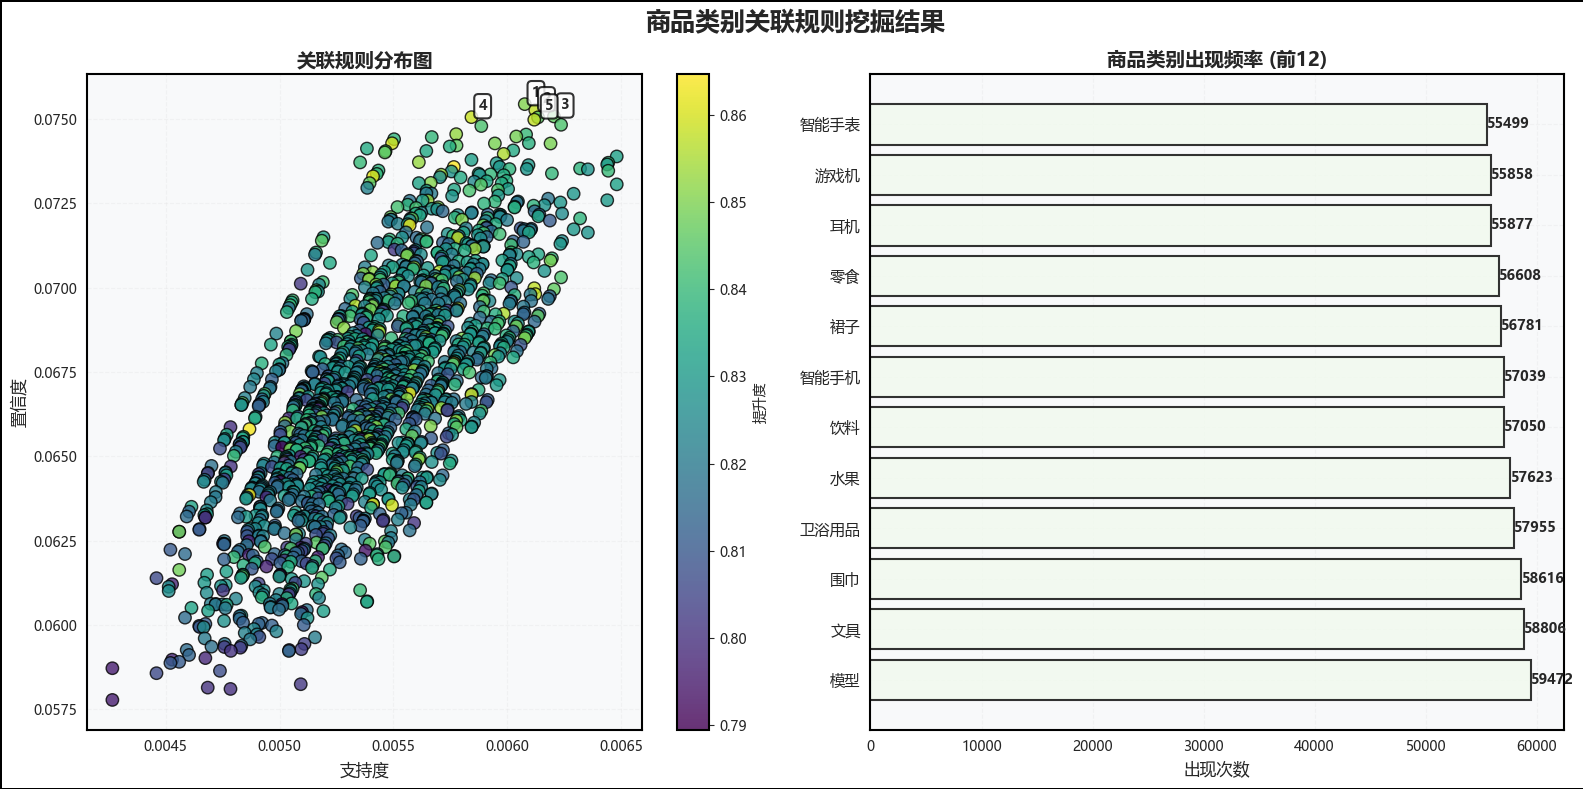


=== 可视化图表数值结果 ===
关联规则分布图数值 (前5条规则):
规则1: 帽子 => 模型
  支持度: 0.0061, 置信度: 0.0754, 提升度: 0.8503
规则2: 婴儿用品 => 文具
  支持度: 0.0061, 置信度: 0.0753, 提升度: 0.8578
规则3: 益智玩具 => 模型
  支持度: 0.0062, 置信度: 0.0751, 提升度: 0.8462
规则4: 玩具 => 围巾
  支持度: 0.0058, 置信度: 0.0751, 提升度: 0.8583
规则5: 儿童课外读物 => 模型
  支持度: 0.0061, 置信度: 0.0750, 提升度: 0.8458

商品类别出现频率前12:
1. 模型: 59472 次
2. 文具: 58806 次
3. 围巾: 58616 次
4. 卫浴用品: 57955 次
5. 水果: 57623 次
6. 饮料: 57050 次
7. 智能手机: 57039 次
8. 裙子: 56781 次
9. 零食: 56608 次
10. 耳机: 55877 次
11. 游戏机: 55858 次
12. 智能手表: 55499 次

=== 任务1完成 ===
频繁项集结果已保存到 frequent_itemsets_task1.csv
关联规则结果已保存到 association_rules_task1.csv


In [3]:
print("=" * 50)
print("任务1：商品类别关联规则挖掘")
print("=" * 50)

# 1. 准备商品类别交易数据
print("\n=== 1. 准备商品类别交易数据 ===")

# 获取每个订单的商品类别组合（去重）
category_transactions = []
for categories in df_processed['unique_categories']:
    if len(categories) > 1:  # 只考虑购买多个类别的订单
        category_transactions.append(categories)

print(f"多类别订单数量: {len(category_transactions)}")

# 统计各类别出现频率
all_categories = [cat for transaction in category_transactions for cat in transaction]
category_freq = pd.Series(all_categories).value_counts()
print(f"\n类别频率分布 (前10):")
for i, (category, count) in enumerate(category_freq.head(10).items()):
    print(f"{i+1}. {category}: {count} 次")

# 2. 使用TransactionEncoder转换数据
print("\n=== 2. 转换数据格式 ===")
te = TransactionEncoder()
te_ary = te.fit(category_transactions).transform(category_transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"转换后数据形状: {df_encoded.shape}")
print(f"包含的商品类别数量: {len(te.columns_)}")

# 3. 挖掘频繁项集
print("\n=== 3. 挖掘频繁项集 ===")
min_support = 0.002  # 支持度 >= 0.02

frequent_itemsets = apriori(df_encoded,
                          min_support=min_support,
                          use_colnames=True,
                          verbose=1)

print(f"找到 {len(frequent_itemsets)} 个频繁项集")

if len(frequent_itemsets) > 0:
    print("\n频繁项集详情 (按支持度排序):")
    frequent_sorted = frequent_itemsets.sort_values('support', ascending=False)
    for i, (idx, row) in enumerate(frequent_sorted.iterrows()):
        itemset_str = ', '.join(list(row['itemsets']))
        print(f"{i+1}. [{itemset_str}] - 支持度: {row['support']:.4f}")

# 4. 生成关联规则
print("\n=== 4. 生成关联规则 ===")
min_confidence = 0.05  # 置信度 >= 0.5

if len(frequent_itemsets) > 0:
    rules = association_rules(frequent_itemsets,
                            metric="confidence",
                            min_threshold=min_confidence)

    if len(rules) > 0:
        # 计算提升度
        rules['lift'] = rules['confidence'] / rules['consequent support']

        # 按置信度排序
        rules_sorted = rules.sort_values(['confidence', 'support'], ascending=False)

        print(f"找到 {len(rules_sorted)} 条关联规则")
        print("\n关联规则详情 (前10条):")
        for i, (idx, rule) in enumerate(rules_sorted.head(10).iterrows()):
            antecedents = ', '.join(list(rule['antecedents']))
            consequents = ', '.join(list(rule['consequents']))
            print(f"{i+1}. {antecedents} => {consequents}")
            print(f"   支持度: {rule['support']:.4f} | 置信度: {rule['confidence']:.4f} | 提升度: {rule['lift']:.4f}")
    else:
        print("未找到满足条件的关联规则")
        rules_sorted = pd.DataFrame()
else:
    print("未找到频繁项集")
    rules_sorted = pd.DataFrame()

# 5. 特别关注电子产品关联
print("\n=== 5. 电子产品关联分析 ===")
electronic_categories = ['智能手机', '笔记本电脑', '平板电脑', '智能手表', '耳机', '音响', '相机', '摄像机', '游戏机']

# 筛选包含电子产品的规则
if len(rules_sorted) > 0:
    electronic_rules = rules_sorted[
        rules_sorted['antecedents'].apply(lambda x: any(cat in electronic_categories for cat in x)) |
        rules_sorted['consequents'].apply(lambda x: any(cat in electronic_categories for cat in x))
    ]

    print(f"涉及电子产品的关联规则数量: {len(electronic_rules)}")
    if len(electronic_rules) > 0:
        print("\n电子产品相关规则 (前5条):")
        for i, (idx, rule) in enumerate(electronic_rules.head(5).iterrows()):
            antecedents = ', '.join(list(rule['antecedents']))
            consequents = ', '.join(list(rule['consequents']))
            print(f"{i+1}. {antecedents} => {consequents}")
            print(f"   支持度: {rule['support']:.4f} | 置信度: {rule['confidence']:.4f} | 提升度: {rule['lift']:.4f}")

# 6. 可视化结果 - 只显示前两个图
print("\n=== 6. 可视化分析结果 ===")

if len(frequent_itemsets) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor('white')
    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(2)

    # 调整子图间距，为标题留出空间
    plt.subplots_adjust(top=0.85)
    fig.suptitle('商品类别关联规则挖掘结果', fontsize=18, fontweight='bold')

    # 6.1 关联规则散点图(支持度vs置信度，颜色表示提升度)
    if len(rules_sorted) > 0:
        scatter = axes[0].scatter(rules_sorted['support'], rules_sorted['confidence'],
                                c=rules_sorted['lift'], cmap='viridis',
                                edgecolors='black', linewidth=1, alpha=0.8, s=80)
        axes[0].set_title('关联规则分布图', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('支持度', fontsize=12)
        axes[0].set_ylabel('置信度', fontsize=12)
        axes[0].grid(True, alpha=0.3)

        # 添加颜色条
        cbar = plt.colorbar(scatter, ax=axes[0])
        cbar.set_label('提升度', fontsize=10)

        # 添加数值标注(只标注前5个点)
        for i, (idx, rule) in enumerate(rules_sorted.head(5).iterrows()):
            axes[0].annotate(f'{i+1}',
                           (rule['support'], rule['confidence']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # 如果没有关联规则，显示项集长度分布
        itemset_lengths = frequent_itemsets['itemsets'].apply(len)
        length_counts = itemset_lengths.value_counts().sort_index()
        bars1 = axes[0].bar(length_counts.index, length_counts.values,
                           color='#a8dadc', edgecolor='black', linewidth=1.5, alpha=0.8)
        axes[0].set_title('频繁项集长度分布', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('项集长度', fontsize=12)
        axes[0].set_ylabel('数量', fontsize=12)
        axes[0].grid(True, alpha=0.3)

        # 添加数值标注
        for bar in bars1:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{int(height)}', ha='center', va='bottom',
                        fontsize=10, fontweight='bold')

    # 6.2 类别频率分布
    top_categories = category_freq.head(12)
    bars2 = axes[1].barh(range(len(top_categories)), top_categories.values,
                        color='#f1faee', edgecolor='black', linewidth=1.5, alpha=0.8)
    axes[1].set_yticks(range(len(top_categories)))
    axes[1].set_yticklabels(top_categories.index, fontsize=11)
    axes[1].set_title('商品类别出现频率 (前12)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('出现次数', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    # 添加数值标注
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                    f'{int(width)}', ha='left', va='center',
                    fontsize=10, fontweight='bold')

    # 美化边框
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # 打印可视化结果的数值
    print("\n=== 可视化图表数值结果 ===")
    if len(rules_sorted) > 0:
        print("关联规则分布图数值 (前5条规则):")
        for i, (idx, rule) in enumerate(rules_sorted.head(5).iterrows()):
            antecedents = ', '.join(list(rule['antecedents']))
            consequents = ', '.join(list(rule['consequents']))
            print(f"规则{i+1}: {antecedents} => {consequents}")
            print(f"  支持度: {rule['support']:.4f}, 置信度: {rule['confidence']:.4f}, 提升度: {rule['lift']:.4f}")
    else:
        print("频繁项集长度分布数值:")
        itemset_lengths = frequent_itemsets['itemsets'].apply(len)
        length_counts = itemset_lengths.value_counts().sort_index()
        for length, count in length_counts.items():
            print(f"长度{length}: {count} 个项集")

    print("\n商品类别出现频率前12:")
    for i, (category, count) in enumerate(top_categories.items()):
        print(f"{i+1}. {category}: {count} 次")

print("\n=== 任务1完成 ===")

# 保存结果
if len(frequent_itemsets) > 0:
    frequent_itemsets.to_csv('frequent_itemsets_task1.csv', index=False)
    print("频繁项集结果已保存到 frequent_itemsets_task1.csv")

if 'rules_sorted' in locals() and len(rules_sorted) > 0:
    rules_sorted.to_csv('association_rules_task1.csv', index=False)
    print("关联规则结果已保存到 association_rules_task1.csv")

任务2：支付方式与商品类别关联分析

=== 1. 支付方式与商品类别数据准备 ===
交易记录数量: 843096

支付方式分布:
1. 信用卡: 120766 次 (14.32%)
2. 支付宝: 120574 次 (14.30%)
3. 储蓄卡: 120492 次 (14.29%)
4. 云闪付: 120487 次 (14.29%)
5. 现金: 120476 次 (14.29%)
6. 银联: 120389 次 (14.28%)
7. 微信支付: 119912 次 (14.22%)

=== 2. 挖掘支付方式与商品类别关联 ===
转换后数据形状: (843096, 49)
Processing 3657 combinations | Sampling itemset size 3
找到 169 个频繁项集

=== 3. 高价值商品支付方式分析 ===
高价值购买记录数量: 290008

高价值商品支付方式分布:
1. 支付宝: 41572 次 (14.33%)
2. 信用卡: 41526 次 (14.32%)
3. 银联: 41513 次 (14.31%)
4. 云闪付: 41491 次 (14.31%)
5. 现金: 41376 次 (14.27%)
6. 储蓄卡: 41312 次 (14.25%)
7. 微信支付: 41218 次 (14.21%)

高价值商品类别分布 (前8):
1. 笔记本电脑: 56471 次
2. 相机: 54745 次
3. 家具: 46088 次
4. 平板电脑: 45311 次
5. 智能手机: 45243 次
6. 摄像机: 44378 次
7. 游戏机: 38520 次
8. 健身器材: 30989 次

=== 4. 各支付方式详细统计 ===
各支付方式统计:
支付方式       平均金额       中位数        订单数        总金额         
------------------------------------------------------------
云闪付        4798.65    2921.22    120487.0   578175176.08
信用卡        4797.68    2938.94    120766.0   5793961

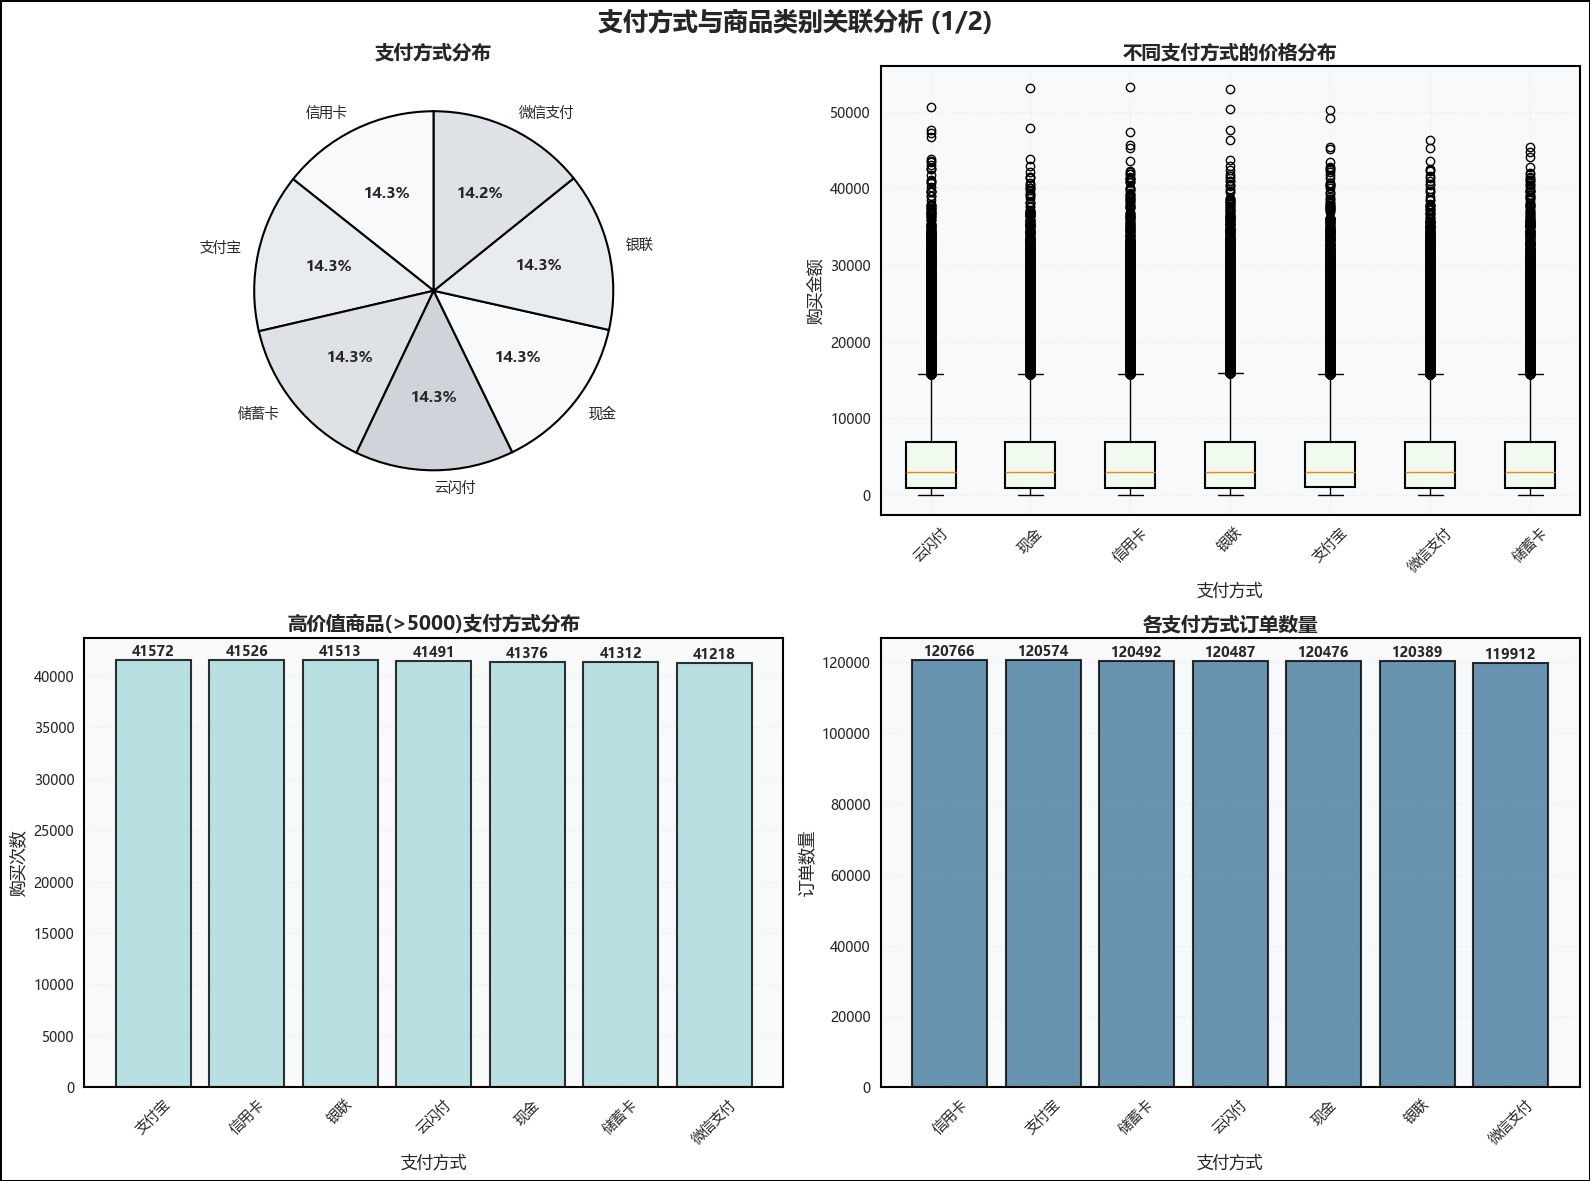

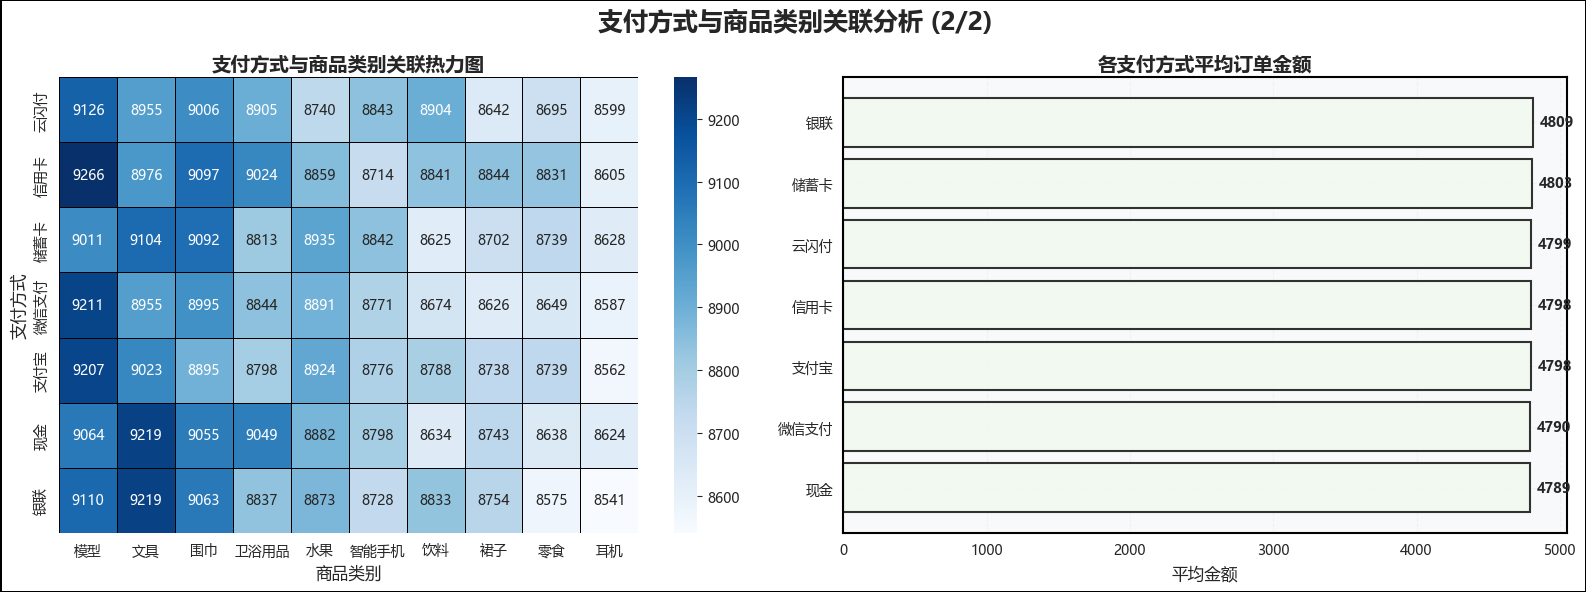


=== 可视化图表数值结果 ===
支付方式分布数值:
信用卡: 120766 (14.3%)
支付宝: 120574 (14.3%)
储蓄卡: 120492 (14.3%)
云闪付: 120487 (14.3%)
现金: 120476 (14.3%)
银联: 120389 (14.3%)
微信支付: 119912 (14.2%)

高价值商品支付方式数值:
支付宝: 41572 次
信用卡: 41526 次
银联: 41513 次
云闪付: 41491 次
现金: 41376 次
储蓄卡: 41312 次
微信支付: 41218 次

各支付方式平均订单金额:
现金: 4789.35
微信支付: 4790.16
支付宝: 4797.66
信用卡: 4797.68
云闪付: 4798.65
储蓄卡: 4803.36
银联: 4808.93

=== 任务2完成 ===
支付方式频繁项集已保存到 payment_frequent_itemsets_task2.csv


In [4]:
print("=" * 50)
print("任务2：支付方式与商品类别关联分析")
print("=" * 50)

# 1. 数据准备
print("\n=== 1. 支付方式与商品类别数据准备 ===")

# 创建支付方式+商品类别的交易数据
payment_category_transactions = []
for idx, row in df_processed.iterrows():
    # 将支付方式和商品类别组合
    transaction = [f"支付方式_{row['payment_method']}"] + [f"类别_{cat}" for cat in row['unique_categories']]
    payment_category_transactions.append(transaction)

print(f"交易记录数量: {len(payment_category_transactions)}")

# 统计支付方式分布
payment_methods = df_processed['payment_method'].value_counts()
print(f"\n支付方式分布:")
for i, (method, count) in enumerate(payment_methods.items()):
    percentage = count / len(df_processed) * 100
    print(f"{i+1}. {method}: {count} 次 ({percentage:.2f}%)")

# 2. 挖掘支付方式与商品类别关联
print("\n=== 2. 挖掘支付方式与商品类别关联 ===")

# 转换数据格式
te_payment = TransactionEncoder()
te_payment_ary = te_payment.fit(payment_category_transactions).transform(payment_category_transactions)
df_payment_encoded = pd.DataFrame(te_payment_ary, columns=te_payment.columns_)

print(f"转换后数据形状: {df_payment_encoded.shape}")

# 挖掘频繁项集
min_support_payment = 0.01  # 支持度 >= 0.01
frequent_itemsets_payment = apriori(df_payment_encoded,
                                  min_support=min_support_payment,
                                  use_colnames=True,
                                  verbose=1)

print(f"找到 {len(frequent_itemsets_payment)} 个频繁项集")

# 生成关联规则
min_confidence_payment = 0.6  # 置信度 >= 0.6

if len(frequent_itemsets_payment) > 0:
    rules_payment = association_rules(frequent_itemsets_payment,
                                    metric="confidence",
                                    min_threshold=min_confidence_payment)

    if len(rules_payment) > 0:
        # 计算提升度
        rules_payment['lift'] = rules_payment['confidence'] / rules_payment['consequent support']
        rules_payment_sorted = rules_payment.sort_values(['confidence', 'support'], ascending=False)

        print(f"找到 {len(rules_payment_sorted)} 条关联规则")

        # 筛选涉及支付方式的规则
        payment_rules = rules_payment_sorted[
            rules_payment_sorted['antecedents'].apply(lambda x: any('支付方式_' in str(item) for item in x)) |
            rules_payment_sorted['consequents'].apply(lambda x: any('支付方式_' in str(item) for item in x))
        ]

        print(f"\n涉及支付方式的关联规则数量: {len(payment_rules)}")
        if len(payment_rules) > 0:
            print("\n支付方式关联规则 (前8条):")
            for i, (idx, rule) in enumerate(payment_rules.head(8).iterrows()):
                antecedents = ', '.join([str(x) for x in rule['antecedents']])
                consequents = ', '.join([str(x) for x in rule['consequents']])
                print(f"{i+1}. {antecedents} => {consequents}")
                print(f"   支持度: {rule['support']:.4f} | 置信度: {rule['confidence']:.4f} | 提升度: {rule['lift']:.4f}")

# 3. 高价值商品支付方式分析
print("\n=== 3. 高价值商品支付方式分析 ===")

# 筛选高价值商品(价格>5000)
high_value_purchases = df_processed[df_processed['total_price'] > 5000].copy()
print(f"高价值购买记录数量: {len(high_value_purchases)}")

if len(high_value_purchases) > 0:
    # 高价值商品的支付方式分布
    high_value_payment = high_value_purchases['payment_method'].value_counts()
    print(f"\n高价值商品支付方式分布:")
    for i, (payment, count) in enumerate(high_value_payment.items()):
        percentage = count / len(high_value_purchases) * 100
        print(f"{i+1}. {payment}: {count} 次 ({percentage:.2f}%)")

    # 高价值商品的类别分布
    high_value_categories = []
    for categories in high_value_purchases['unique_categories']:
        high_value_categories.extend(categories)

    high_value_cat_freq = pd.Series(high_value_categories).value_counts()
    print(f"\n高价值商品类别分布 (前8):")
    for i, (category, count) in enumerate(high_value_cat_freq.head(8).items()):
        print(f"{i+1}. {category}: {count} 次")

# 4. 各支付方式详细统计
print("\n=== 4. 各支付方式详细统计 ===")

# 各支付方式的平均订单价值
payment_stats = df_processed.groupby('payment_method')['total_price'].agg(['mean', 'median', 'count', 'sum']).round(2)
print("各支付方式统计:")
print(f"{'支付方式':<10} {'平均金额':<10} {'中位数':<10} {'订单数':<10} {'总金额':<12}")
print("-" * 60)
for payment, stats in payment_stats.iterrows():
    print(f"{payment:<10} {stats['mean']:<10} {stats['median']:<10} {stats['count']:<10} {stats['sum']:<12}")

# 各支付方式偏好的商品类别分析
print("\n各支付方式偏好的商品类别 (前3个):")
for payment in df_processed['payment_method'].unique():
    if pd.notna(payment) and payment != '':
        payment_data = df_processed[df_processed['payment_method'] == payment]
        categories = []
        for cats in payment_data['unique_categories']:
            categories.extend(cats)
        if categories:
            top_categories = pd.Series(categories).value_counts().head(3)
            print(f"\n{payment}:")
            for i, (cat, count) in enumerate(top_categories.items()):
                print(f"  {i+1}. {cat}: {count} 次")

# 5. 可视化分析 - 分为两张大图
print("\n=== 5. 可视化支付方式关联分析 ===")

# 第一张大图 - 4个子图
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.patch.set_facecolor('white')
fig1.patch.set_edgecolor('black')
fig1.patch.set_linewidth(2)
plt.subplots_adjust(top=0.9)
fig1.suptitle('支付方式与商品类别关联分析 (1/2)', fontsize=18, fontweight='bold')

# 5.1 支付方式分布饼图
colors1 = ['#f8f9fa', '#e9ecef', '#dee2e6', '#ced4da']
wedges, texts, autotexts = axes1[0,0].pie(payment_methods.values, labels=payment_methods.index,
                                         autopct='%1.1f%%', startangle=90, colors=colors1,
                                         wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes1[0,0].set_title('支付方式分布', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# 5.2 支付方式与价格关系箱线图
payment_price_data = []
payment_labels = []
for payment in df_processed['payment_method'].unique():
    if pd.notna(payment) and payment != '':
        prices = df_processed[df_processed['payment_method'] == payment]['total_price']
        if len(prices) > 0:
            payment_price_data.append(prices)
            payment_labels.append(payment)

if payment_price_data:
    bp = axes1[0,1].boxplot(payment_price_data, labels=payment_labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('#f1faee')
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
    axes1[0,1].set_title('不同支付方式的价格分布', fontsize=14, fontweight='bold')
    axes1[0,1].set_xlabel('支付方式', fontsize=12)
    axes1[0,1].set_ylabel('购买金额', fontsize=12)
    axes1[0,1].tick_params(axis='x', rotation=45)
    axes1[0,1].grid(True, alpha=0.3)

# 5.3 高价值商品支付方式
if len(high_value_purchases) > 0:
    bars3 = axes1[1,0].bar(range(len(high_value_payment)), high_value_payment.values,
                          color='#a8dadc', edgecolor='black', linewidth=1.5, alpha=0.8)
    axes1[1,0].set_xticks(range(len(high_value_payment)))
    axes1[1,0].set_xticklabels(high_value_payment.index, rotation=45)
    axes1[1,0].set_title('高价值商品(>5000)支付方式分布', fontsize=14, fontweight='bold')
    axes1[1,0].set_xlabel('支付方式', fontsize=12)
    axes1[1,0].set_ylabel('购买次数', fontsize=12)
    axes1[1,0].grid(True, alpha=0.3)

    # 添加数值标注
    for bar in bars3:
        height = bar.get_height()
        axes1[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{int(height)}', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

# 5.4 支付方式订单数量对比
bars4 = axes1[1,1].bar(range(len(payment_methods)), payment_methods.values,
                      color='#457b9d', edgecolor='black', linewidth=1.5, alpha=0.8)
axes1[1,1].set_xticks(range(len(payment_methods)))
axes1[1,1].set_xticklabels(payment_methods.index, rotation=45)
axes1[1,1].set_title('各支付方式订单数量', fontsize=14, fontweight='bold')
axes1[1,1].set_xlabel('支付方式', fontsize=12)
axes1[1,1].set_ylabel('订单数量', fontsize=12)
axes1[1,1].grid(True, alpha=0.3)

# 添加数值标注
for bar in bars4:
    height = bar.get_height()
    axes1[1,1].text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{int(height)}', ha='center', va='bottom',
                   fontsize=10, fontweight='bold')

# 美化边框
for ax in axes1.flat:
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# 第二张大图 - 2个子图
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
fig2.patch.set_facecolor('white')
fig2.patch.set_edgecolor('black')
fig2.patch.set_linewidth(2)
plt.subplots_adjust(top=0.85)
fig2.suptitle('支付方式与商品类别关联分析 (2/2)', fontsize=18, fontweight='bold')

# 5.5 支付方式与商品类别热力图
if len(df_processed) > 0:
    # 创建支付方式与类别的交叉表
    payment_category_cross = []
    for idx, row in df_processed.iterrows():
        for category in row['unique_categories']:
            payment_category_cross.append({
                'payment_method': row['payment_method'],
                'category': category
            })

    if payment_category_cross:
        df_cross = pd.DataFrame(payment_category_cross)
        cross_table = pd.crosstab(df_cross['payment_method'], df_cross['category'])

        # 选择前10个最频繁的类别
        top_categories = cross_table.sum().nlargest(10).index
        cross_table_top = cross_table[top_categories]

        sns.heatmap(cross_table_top, annot=True, fmt='d', cmap='Blues',
                   ax=axes2[0], linewidths=0.5, linecolor='black')
        axes2[0].set_title('支付方式与商品类别关联热力图', fontsize=14, fontweight='bold')
        axes2[0].set_xlabel('商品类别', fontsize=12)
        axes2[0].set_ylabel('支付方式', fontsize=12)

# 5.6 平均订单金额对比
avg_amounts = payment_stats['mean'].sort_values(ascending=True)
bars6 = axes2[1].barh(range(len(avg_amounts)), avg_amounts.values,
                     color='#f1faee', edgecolor='black', linewidth=1.5, alpha=0.8)
axes2[1].set_yticks(range(len(avg_amounts)))
axes2[1].set_yticklabels(avg_amounts.index)
axes2[1].set_title('各支付方式平均订单金额', fontsize=14, fontweight='bold')
axes2[1].set_xlabel('平均金额', fontsize=12)
axes2[1].grid(True, alpha=0.3)

# 添加数值标注
for i, bar in enumerate(bars6):
    width = bar.get_width()
    axes2[1].text(width + 50, bar.get_y() + bar.get_height()/2.,
                 f'{width:.0f}', ha='left', va='center',
                 fontsize=10, fontweight='bold')

# 美化边框
for ax in axes2:
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# 打印可视化结果数值
print("\n=== 可视化图表数值结果 ===")
print("支付方式分布数值:")
for method, count in payment_methods.items():
    percentage = count / len(df_processed) * 100
    print(f"{method}: {count} ({percentage:.1f}%)")

if len(high_value_purchases) > 0:
    print("\n高价值商品支付方式数值:")
    for payment, count in high_value_payment.items():
        print(f"{payment}: {count} 次")

print("\n各支付方式平均订单金额:")
for payment, amount in avg_amounts.items():
    print(f"{payment}: {amount:.2f}")

print("\n=== 任务2完成 ===")

# 保存结果
if 'rules_payment_sorted' in locals() and len(rules_payment_sorted) > 0:
    rules_payment_sorted.to_csv('payment_association_rules_task2.csv', index=False)
    print("支付方式关联规则已保存到 payment_association_rules_task2.csv")

if 'frequent_itemsets_payment' in locals() and len(frequent_itemsets_payment) > 0:
    frequent_itemsets_payment.to_csv('payment_frequent_itemsets_task2.csv', index=False)
    print("支付方式频繁项集已保存到 payment_frequent_itemsets_task2.csv")

任务3：时间序列模式挖掘

=== 1. 季节性模式分析 ===
有效时间数据量: 843096

年份购买模式:
年份       订单数      平均金额       总金额          平均商品数     
-------------------------------------------------------
2020     161501.0 4793.24    774112918.85 3.0       
2021     161259.0 4786.28    771831102.58 3.0       
2022     161177.0 4793.18    772550701.26 2.99      
2023     161187.0 4796.07    773064481.14 3.0       
2024     161380.0 4822.48    778252228.11 3.0       
2025     36592.0  4791.77    175340413.09 2.99      

年月购买模式 (前8个月):
年月         订单数      平均金额       总金额          平均商品数     
------------------------------------------------------------
2020-01    13655.0  4831.49    65974021.13  2.99      
2020-02    12641.0  4774.98    60360470.41  3.01      
2020-03    13727.0  4803.43    65936746.19  3.0       
2020-04    13227.0  4772.19    63121812.34  2.99      
2020-05    13677.0  4818.02    65896086.16  3.01      
2020-06    13130.0  4802.41    63055659.81  2.99      
2020-07    13639.0  4735.01    64580779.87  3.02     

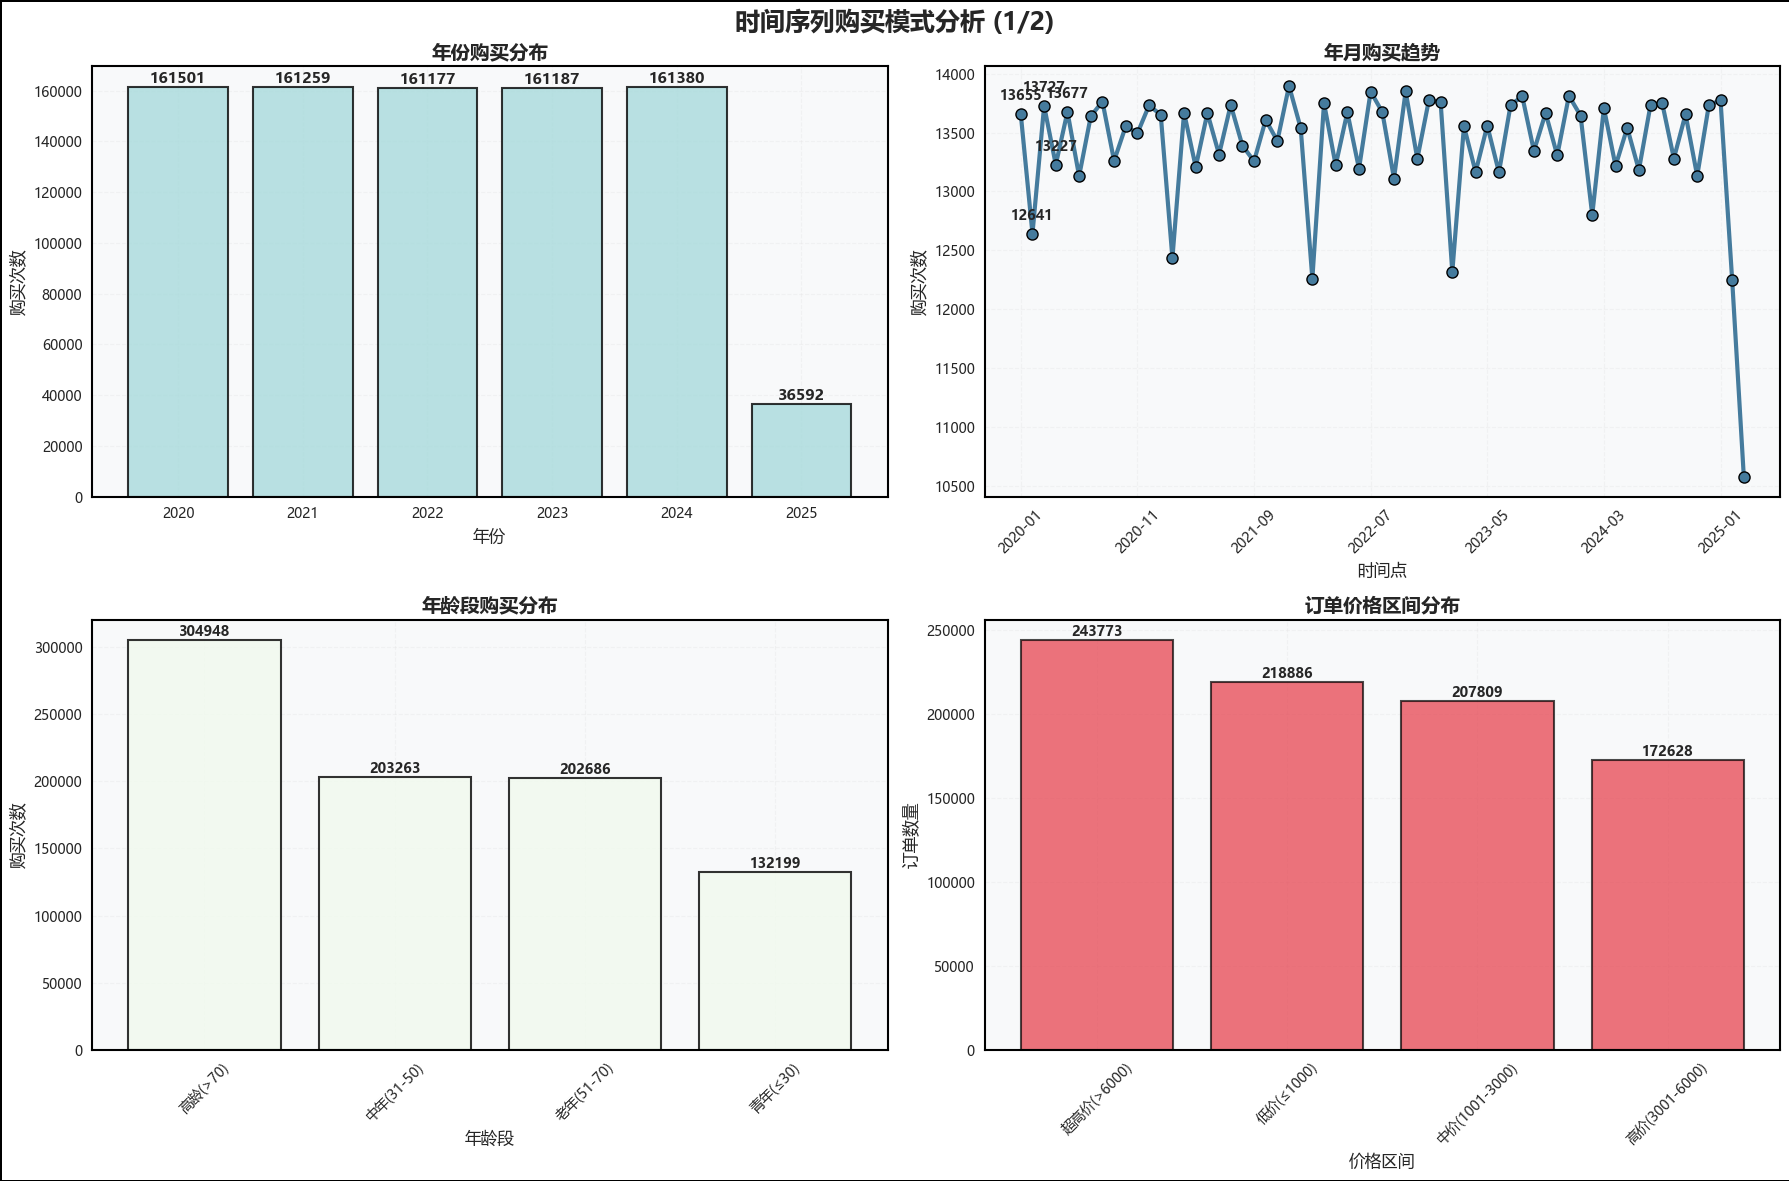

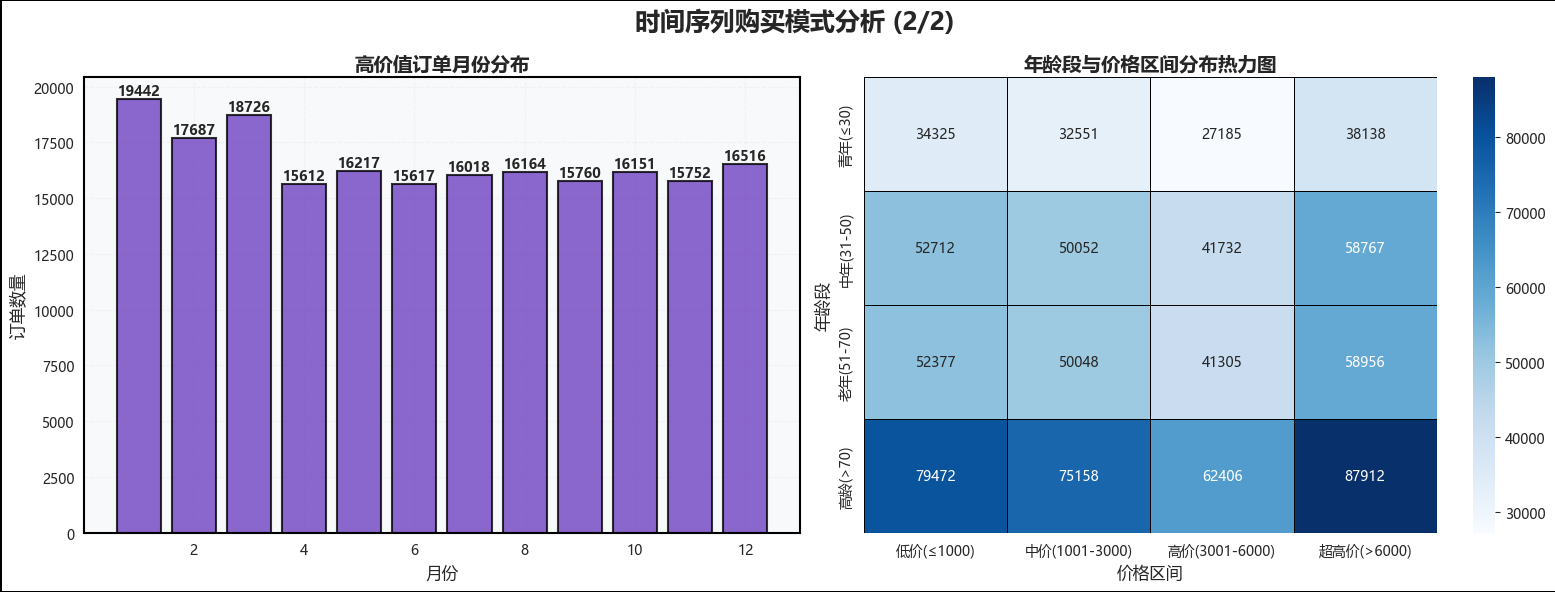


=== 可视化图表数值结果 ===
年份购买分布数值:
2020年: 161501 次
2021年: 161259 次
2022年: 161177 次
2023年: 161187 次
2024年: 161380 次
2025年: 36592 次

年月趋势数值 (前8个时间点):
2020-01: 13655 次
2020-02: 12641 次
2020-03: 13727 次
2020-04: 13227 次
2020-05: 13677 次
2020-06: 13130 次
2020-07: 13639 次
2020-08: 13764 次

年龄段购买分布数值:
高龄(>70): 304948 次
中年(31-50): 203263 次
老年(51-70): 202686 次
青年(≤30): 132199 次

价格区间分布数值:
超高价(>6000): 243773 次
低价(≤1000): 218886 次
中价(1001-3000): 207809 次
高价(3001-6000): 172628 次

高价值订单月份分布数值:
1月: 19442 次
2月: 17687 次
3月: 18726 次
4月: 15612 次
5月: 16217 次
6月: 15617 次
7月: 16018 次
8月: 16164 次
9月: 15760 次
10月: 16151 次
11月: 15752 次
12月: 16516 次

=== 任务3完成 ===
季节性模式结果已保存到CSV文件
时序模式分析完成


In [5]:
print("=" * 50)
print("任务3：时间序列模式挖掘")
print("=" * 50)

# 1. 季节性模式分析
print("\n=== 1. 季节性模式分析 ===")

# 确保有有效的时间数据
df_temporal = df_processed.dropna(subset=['purchase_date']).copy()
print(f"有效时间数据量: {len(df_temporal)}")

# 初始化所有统计变量（确保都有定义）
yearly_stats = pd.DataFrame()
year_month_stats = pd.DataFrame()
quarterly_stats = pd.DataFrame()
monthly_stats = pd.DataFrame()
weekday_stats = pd.DataFrame()

if len(df_temporal) > 0:
    # 按年份分析
    yearly_stats = df_temporal.groupby('year').agg({
        'user_id': 'count',
        'total_price': ['mean', 'sum'],
        'item_count': 'mean'
    }).round(2)

    print("\n年份购买模式:")
    print(f"{'年份':<8} {'订单数':<8} {'平均金额':<10} {'总金额':<12} {'平均商品数':<10}")
    print("-" * 55)
    for year, stats in yearly_stats.iterrows():
        print(f"{year:<8} {stats[('user_id', 'count')]:<8} {stats[('total_price', 'mean')]:<10} {stats[('total_price', 'sum')]:<12} {stats[('item_count', 'mean')]:<10}")

    # 按年月组合分析
    df_temporal['year_month'] = df_temporal['purchase_date'].dt.to_period('M')
    year_month_stats = df_temporal.groupby('year_month').agg({
        'user_id': 'count',
        'total_price': ['mean', 'sum'],
        'item_count': 'mean'
    }).round(2)

    print("\n年月购买模式 (前8个月):")
    print(f"{'年月':<10} {'订单数':<8} {'平均金额':<10} {'总金额':<12} {'平均商品数':<10}")
    print("-" * 60)
    for year_month, stats in year_month_stats.head(8).iterrows():
        print(f"{year_month!s:<10} {stats[('user_id', 'count')]:<8} {stats[('total_price', 'mean')]:<10} {stats[('total_price', 'sum')]:<12} {stats[('item_count', 'mean')]:<10}")

    # 按季度分析
    quarterly_stats = df_temporal.groupby('quarter').agg({
        'user_id': 'count',
        'total_price': ['mean', 'sum'],
        'item_count': 'mean'
    }).round(2)

    print("\n季度购买模式:")
    print(f"{'季度':<6} {'订单数':<8} {'平均金额':<10} {'总金额':<12} {'平均商品数':<10}")
    print("-" * 50)
    for quarter, stats in quarterly_stats.iterrows():
        print(f"Q{quarter:<5} {stats[('user_id', 'count')]:<8} {stats[('total_price', 'mean')]:<10} {stats[('total_price', 'sum')]:<12} {stats[('item_count', 'mean')]:<10}")

    # 按月份分析
    monthly_stats = df_temporal.groupby('month').agg({
        'user_id': 'count',
        'total_price': ['mean', 'sum'],
        'item_count': 'mean'
    }).round(2)

    print("\n月份购买模式:")
    print(f"{'月份':<6} {'订单数':<8} {'平均金额':<10} {'总金额':<12} {'平均商品数':<10}")
    print("-" * 50)
    for month, stats in monthly_stats.iterrows():
        print(f"{month}月{'':<4} {stats[('user_id', 'count')]:<8} {stats[('total_price', 'mean')]:<10} {stats[('total_price', 'sum')]:<12} {stats[('item_count', 'mean')]:<10}")

    # 按星期分析
    weekday_stats = df_temporal.groupby('weekday').agg({
        'user_id': 'count',
        'total_price': ['mean', 'sum']
    }).round(2)

    weekday_chinese = {
        'Monday': '周一', 'Tuesday': '周二', 'Wednesday': '周三',
        'Thursday': '周四', 'Friday': '周五', 'Saturday': '周六', 'Sunday': '周日'
    }

    print("\n星期购买模式:")
    print(f"{'星期':<6} {'订单数':<8} {'平均金额':<10} {'总金额':<12}")
    print("-" * 40)
    for weekday, stats in weekday_stats.iterrows():
        chinese_day = weekday_chinese.get(weekday, weekday)
        print(f"{chinese_day:<6} {stats[('user_id', 'count')]:<8} {stats[('total_price', 'mean')]:<10} {stats[('total_price', 'sum')]:<12}")

# 2. 商品类别的时间模式分析
print("\n=== 2. 商品类别的时间模式分析 ===")

# 展开类别数据以便分析
category_temporal_data = []
for idx, row in df_temporal.iterrows():
    for category in row['unique_categories']:
        category_temporal_data.append({
            'category': category,
            'quarter': row['quarter'],
            'month': row['month'],
            'weekday': row['weekday'],
            'year': row['year'],
            'price': row['total_price'],
            'purchase_date': row['purchase_date']
        })

df_cat_temporal = pd.DataFrame(category_temporal_data)

if len(df_cat_temporal) > 0:
    # 各类别的季度分布
    category_quarter = pd.crosstab(df_cat_temporal['category'], df_cat_temporal['quarter'])
    print(f"\n商品类别季度分布 (前8个类别):")
    print(f"{'类别':<12} {'Q1':<6} {'Q2':<6} {'Q3':<6} {'Q4':<6}")
    print("-" * 40)
    for category, quarters in category_quarter.head(8).iterrows():
        print(f"{category:<12} {quarters.get(1,0):<6} {quarters.get(2,0):<6} {quarters.get(3,0):<6} {quarters.get(4,0):<6}")

    # 找出季节性最强的类别
    category_seasonal = category_quarter.std(axis=1).sort_values(ascending=False)
    print(f"\n季节性波动最大的商品类别 (前8):")
    for i, (category, std_val) in enumerate(category_seasonal.head(8).items()):
        print(f"{i+1}. {category}: 标准差 {std_val:.2f}")

# 3. 高价值订单时间分布分析
print("\n=== 3. 高价值订单时间分布分析 ===")

# 定义高价值订单（价格大于平均价格的1.5倍）
avg_price = df_temporal['total_price'].mean()
high_value_threshold = avg_price * 1.5
high_value_orders = df_temporal[df_temporal['total_price'] > high_value_threshold]

print(f"平均订单金额: {avg_price:.2f}")
print(f"高价值订单阈值: {high_value_threshold:.2f}")
print(f"高价值订单数量: {len(high_value_orders)}")

if len(high_value_orders) > 0:
    # 高价值订单的时间分布
    high_value_by_month = high_value_orders['month'].value_counts().sort_index()
    print(f"\n高价值订单月份分布:")
    for month, count in high_value_by_month.items():
        percentage = count / len(high_value_orders) * 100
        print(f"{month}月: {count} 订单 ({percentage:.1f}%)")

    # 高价值订单的星期分布
    high_value_by_weekday = high_value_orders['weekday'].value_counts()
    print(f"\n高价值订单星期分布:")
    for weekday, count in high_value_by_weekday.items():
        chinese_day = weekday_chinese.get(weekday, weekday)
        percentage = count / len(high_value_orders) * 100
        print(f"{chinese_day}: {count} 订单 ({percentage:.1f}%)")

# 4. 支付方式时间偏好分析
print("\n=== 4. 支付方式时间偏好分析 ===")

# 各支付方式的月份偏好
payment_month_cross = pd.crosstab(df_temporal['payment_method'], df_temporal['month'])
print(f"\n各支付方式月份分布:")
print(f"{'支付方式':<12} ", end="")
for month in sorted(df_temporal['month'].unique()):
    print(f"{month}月{'':<4}", end="")
print()
print("-" * 60)

for payment in df_temporal['payment_method'].unique():
    if pd.notna(payment):
        print(f"{payment:<12} ", end="")
        for month in sorted(df_temporal['month'].unique()):
            count = payment_month_cross.loc[payment, month] if month in payment_month_cross.columns else 0
            print(f"{count:<6}", end="")
        print()

# 各支付方式的星期偏好
payment_weekday_cross = pd.crosstab(df_temporal['payment_method'], df_temporal['weekday'])
print(f"\n各支付方式最偏好的购买日:")
for payment in df_temporal['payment_method'].unique():
    if pd.notna(payment) and payment in payment_weekday_cross.index:
        top_weekday = payment_weekday_cross.loc[payment].idxmax()
        top_count = payment_weekday_cross.loc[payment].max()
        chinese_day = weekday_chinese.get(top_weekday, top_weekday)
        print(f"{payment}: {chinese_day} ({top_count}次)")

# 5. 用户年龄段时间购买模式
print("\n=== 5. 用户年龄段时间购买模式 ===")

# 将用户分为年龄段
age_bins = [0, 30, 50, 70, 100]
age_labels = ['青年(≤30)', '中年(31-50)', '老年(51-70)', '高龄(>70)']
df_temporal['age_group'] = pd.cut(df_temporal['age'], bins=age_bins, labels=age_labels, right=True)

# 各年龄段的季度购买偏好
age_quarter_cross = pd.crosstab(df_temporal['age_group'], df_temporal['quarter'])
print(f"\n各年龄段季度购买分布:")
print(f"{'年龄段':<12} Q1{'':<4} Q2{'':<4} Q3{'':<4} Q4{'':<4}")
print("-" * 45)

for age_group in age_labels:
    if age_group in age_quarter_cross.index:
        print(f"{age_group:<12} ", end="")
        for quarter in [1, 2, 3, 4]:
            count = age_quarter_cross.loc[age_group, quarter] if quarter in age_quarter_cross.columns else 0
            print(f"{count:<6}", end="")
        print()

# 各年龄段的平均订单金额
age_avg_amount = df_temporal.groupby('age_group')['total_price'].mean()
print(f"\n各年龄段平均订单金额:")
for age_group, avg_amount in age_avg_amount.items():
    print(f"{age_group}: {avg_amount:.2f}")

# 6. 商品价格区间时间分布
print("\n=== 6. 商品价格区间时间分布 ===")

# 将订单按价格分区间
price_bins = [0, 1000, 3000, 6000, float('inf')]
price_labels = ['低价(≤1000)', '中价(1001-3000)', '高价(3001-6000)', '超高价(>6000)']
df_temporal['price_range'] = pd.cut(df_temporal['total_price'], bins=price_bins, labels=price_labels, right=True)

# 各价格区间的月份分布
price_month_cross = pd.crosstab(df_temporal['price_range'], df_temporal['month'])
print(f"\n各价格区间月份购买分布 (前6个月):")
print(f"{'价格区间':<15} ", end="")
for month in sorted(df_temporal['month'].unique())[:6]:
    print(f"{month}月{'':<4}", end="")
print()
print("-" * 60)

for price_range in price_labels:
    if price_range in price_month_cross.index:
        print(f"{price_range:<15} ", end="")
        for month in sorted(df_temporal['month'].unique())[:6]:
            count = price_month_cross.loc[price_range, month] if month in price_month_cross.columns else 0
            print(f"{count:<6}", end="")
        print()

# 各价格区间的星期偏好
price_weekday_cross = pd.crosstab(df_temporal['price_range'], df_temporal['weekday'])
print(f"\n各价格区间最偏好的购买日:")
for price_range in price_labels:
    if price_range in price_weekday_cross.index:
        top_weekday = price_weekday_cross.loc[price_range].idxmax()
        top_count = price_weekday_cross.loc[price_range].max()
        chinese_day = weekday_chinese.get(top_weekday, top_weekday)
        print(f"{price_range}: {chinese_day} ({top_count}次)")

# 7. 可视化时间序列模式 - 分为两张大图
print("\n=== 7. 可视化时间序列模式 ===")

if len(df_temporal) > 0:
    # 第一张大图 - 4个子图
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))
    fig1.patch.set_facecolor('white')
    fig1.patch.set_edgecolor('black')
    fig1.patch.set_linewidth(2)
    plt.subplots_adjust(top=0.9)
    fig1.suptitle('时间序列购买模式分析 (1/2)', fontsize=18, fontweight='bold')

    # 7.1 年份购买分布（如果有多年数据）或月份分布
    if len(yearly_stats) > 1:
        year_counts = df_temporal['year'].value_counts().sort_index()
        bars1 = axes1[0,0].bar(year_counts.index, year_counts.values,
                              color='#a8dadc', edgecolor='black', linewidth=1.5, alpha=0.8)
        axes1[0,0].set_title('年份购买分布', fontsize=14, fontweight='bold')
        axes1[0,0].set_xlabel('年份', fontsize=12)
        axes1[0,0].set_ylabel('购买次数', fontsize=12)
        axes1[0,0].grid(True, alpha=0.3)

        # 添加数值标注
        for bar in bars1:
            height = bar.get_height()
            axes1[0,0].text(bar.get_x() + bar.get_width()/2., height + 2,
                           f'{int(height)}', ha='center', va='bottom',
                           fontsize=11, fontweight='bold')
    else:
        # 如果只有一年数据，显示月份分布
        month_counts = df_temporal['month'].value_counts().sort_index()
        bars1 = axes1[0,0].bar(month_counts.index, month_counts.values,
                              color='#a8dadc', edgecolor='black', linewidth=1.5, alpha=0.8)
        axes1[0,0].set_title('月份购买分布', fontsize=14, fontweight='bold')
        axes1[0,0].set_xlabel('月份', fontsize=12)
        axes1[0,0].set_ylabel('购买次数', fontsize=12)
        axes1[0,0].grid(True, alpha=0.3)

        # 添加数值标注
        for bar in bars1:
            height = bar.get_height()
            axes1[0,0].text(bar.get_x() + bar.get_width()/2., height + 2,
                           f'{int(height)}', ha='center', va='bottom',
                           fontsize=11, fontweight='bold')

    # 7.2 年月趋势分析
    year_month_counts = df_temporal.groupby('year_month').size()
    axes1[0,1].plot(range(len(year_month_counts)), year_month_counts.values, marker='o',
                   linewidth=3, markersize=8, color='#457b9d', markeredgecolor='black')
    axes1[0,1].set_title('年月购买趋势', fontsize=14, fontweight='bold')
    axes1[0,1].set_xlabel('时间点', fontsize=12)
    axes1[0,1].set_ylabel('购买次数', fontsize=12)
    axes1[0,1].grid(True, alpha=0.3)

    # 设置x轴标签（显示部分年月）
    if len(year_month_counts) > 0:
        step = max(1, len(year_month_counts) // 6)  # 最多显示6个标签
        tick_positions = range(0, len(year_month_counts), step)
        tick_labels = [str(year_month_counts.index[i]) for i in tick_positions]
        axes1[0,1].set_xticks(tick_positions)
        axes1[0,1].set_xticklabels(tick_labels, rotation=45)

    # 添加数值标注（只标注前5个点）
    for i, count in enumerate(year_month_counts.values[:5]):
        axes1[0,1].annotate(f'{count}', (i, count),
                           textcoords="offset points", xytext=(0,10), ha='center',
                           fontsize=10, fontweight='bold')

    # 7.3 年龄段购买分布
    age_counts = df_temporal['age_group'].value_counts()
    bars3 = axes1[1,0].bar(range(len(age_counts)), age_counts.values,
                          color='#f1faee', edgecolor='black', linewidth=1.5, alpha=0.8)
    axes1[1,0].set_title('年龄段购买分布', fontsize=14, fontweight='bold')
    axes1[1,0].set_xlabel('年龄段', fontsize=12)
    axes1[1,0].set_ylabel('购买次数', fontsize=12)
    axes1[1,0].set_xticks(range(len(age_counts)))
    axes1[1,0].set_xticklabels(age_counts.index, rotation=45)
    axes1[1,0].grid(True, alpha=0.3)

    # 添加数值标注
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        axes1[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{int(height)}', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

    # 7.4 价格区间分布
    price_counts = df_temporal['price_range'].value_counts()
    bars4 = axes1[1,1].bar(range(len(price_counts)), price_counts.values,
                          color='#e63946', edgecolor='black', linewidth=1.5, alpha=0.7)
    axes1[1,1].set_title('订单价格区间分布', fontsize=14, fontweight='bold')
    axes1[1,1].set_xlabel('价格区间', fontsize=12)
    axes1[1,1].set_ylabel('订单数量', fontsize=12)
    axes1[1,1].set_xticks(range(len(price_counts)))
    axes1[1,1].set_xticklabels(price_counts.index, rotation=45)
    axes1[1,1].grid(True, alpha=0.3)

    # 添加数值标注
    for bar in bars4:
        height = bar.get_height()
        axes1[1,1].text(bar.get_x() + bar.get_width()/2., height + 5,
                       f'{int(height)}', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

    # 美化边框
    for ax in axes1.flat:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # 第二张大图 - 2个子图
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.patch.set_facecolor('white')
    fig2.patch.set_edgecolor('black')
    fig2.patch.set_linewidth(2)
    plt.subplots_adjust(top=0.85)
    fig2.suptitle('时间序列购买模式分析 (2/2)', fontsize=18, fontweight='bold')

    # 7.5 高价值订单时间分布
    if len(high_value_orders) > 0:
        high_value_month = high_value_orders['month'].value_counts().sort_index()
        bars5 = axes2[0].bar(high_value_month.index, high_value_month.values,
                           color='#6f42c1', edgecolor='black', linewidth=1.5, alpha=0.8)
        axes2[0].set_title('高价值订单月份分布', fontsize=14, fontweight='bold')
        axes2[0].set_xlabel('月份', fontsize=12)
        axes2[0].set_ylabel('订单数量', fontsize=12)
        axes2[0].grid(True, alpha=0.3)

        # 添加数值标注
        for bar in bars5:
            height = bar.get_height()
            axes2[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                         f'{int(height)}', ha='center', va='bottom',
                         fontsize=10, fontweight='bold')
    else:
        # 如果没有高价值订单，显示支付方式月份偏好
        payment_counts = df_temporal['payment_method'].value_counts()
        bars5 = axes2[0].bar(range(len(payment_counts)), payment_counts.values,
                           color='#6f42c1', edgecolor='black', linewidth=1.5, alpha=0.8)
        axes2[0].set_title('支付方式使用分布', fontsize=14, fontweight='bold')
        axes2[0].set_xlabel('支付方式', fontsize=12)
        axes2[0].set_ylabel('使用次数', fontsize=12)
        axes2[0].set_xticks(range(len(payment_counts)))
        axes2[0].set_xticklabels(payment_counts.index, rotation=45)
        axes2[0].grid(True, alpha=0.3)

        # 添加数值标注
        for bar in bars5:
            height = bar.get_height()
            axes2[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                         f'{int(height)}', ha='center', va='bottom',
                         fontsize=10, fontweight='bold')

    # 7.6 年龄段与价格区间热力图
    age_price_crosstab = pd.crosstab(df_temporal['age_group'], df_temporal['price_range'])
    sns.heatmap(age_price_crosstab, annot=True, fmt='d', cmap='Blues',
               ax=axes2[1], linewidths=0.5, linecolor='black')
    axes2[1].set_title('年龄段与价格区间分布热力图', fontsize=14, fontweight='bold')
    axes2[1].set_xlabel('价格区间', fontsize=12)
    axes2[1].set_ylabel('年龄段', fontsize=12)

    # 美化边框
    for ax in axes2:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # 打印可视化结果数值
    print("\n=== 可视化图表数值结果 ===")

    # 根据实际显示的图表打印对应数值
    if len(yearly_stats) > 1:
        print("年份购买分布数值:")
        year_counts = df_temporal['year'].value_counts().sort_index()
        for year, count in year_counts.items():
            print(f"{year}年: {count} 次")
    else:
        print("月份购买分布数值:")
        month_counts = df_temporal['month'].value_counts().sort_index()
        for month, count in month_counts.items():
            print(f"{month}月: {count} 次")

    print("\n年月趋势数值 (前8个时间点):")
    year_month_counts = df_temporal.groupby('year_month').size()
    for i, (year_month, count) in enumerate(year_month_counts.head(8).items()):
        print(f"{year_month}: {count} 次")

    print("\n年龄段购买分布数值:")
    age_counts = df_temporal['age_group'].value_counts()
    for age_group, count in age_counts.items():
        print(f"{age_group}: {count} 次")

    print("\n价格区间分布数值:")
    price_counts = df_temporal['price_range'].value_counts()
    for price_range, count in price_counts.items():
        print(f"{price_range}: {count} 次")

    if len(high_value_orders) > 0:
        print("\n高价值订单月份分布数值:")
        high_value_month = high_value_orders['month'].value_counts().sort_index()
        for month, count in high_value_month.items():
            print(f"{month}月: {count} 次")

print("\n=== 任务3完成 ===")

# 保存结果
if len(df_temporal) > 0:
    yearly_stats.to_csv('yearly_patterns_task3.csv')
    year_month_stats.to_csv('year_month_patterns_task3.csv')
    quarterly_stats.to_csv('quarterly_patterns_task3.csv')
    monthly_stats.to_csv('monthly_patterns_task3.csv')
    weekday_stats.to_csv('weekday_patterns_task3.csv')
    print("季节性模式结果已保存到CSV文件")

print("时序模式分析完成")

任务4：退款模式分析

=== 1. 退款数据概览 ===
支付状态分布:
1. 已支付: 281397 次 (33.38%)
2. 已退款: 281304 次 (33.37%)
3. 部分退款: 280395 次 (33.26%)

退款相关记录数量: 561699
退款率: 66.62%

退款类型分布:
1. 已退款: 281304 次 (50.08%)
2. 部分退款: 280395 次 (49.92%)

退款相关订单金额统计:
平均订单金额: 4795.11
中位数订单金额: 2931.29
总退款涉及金额: 2693409635.31

=== 2. 退款商品类别分析 ===
退款商品类别频率 (前12):
1. 模型: 42520 次
2. 围巾: 42296 次
3. 文具: 42229 次
4. 水果: 41468 次
5. 卫浴用品: 41341 次
6. 智能手机: 40890 次
7. 饮料: 40805 次
8. 裙子: 40646 次
9. 零食: 40635 次
10. 耳机: 40271 次
11. 游戏机: 40190 次
12. 智能手表: 39899 次

各类别退款率 (前12):
1. 床上用品: 总购买56749次, 退款38012次, 退款率66.98%
2. 游戏机: 总购买60025次, 退款40190次, 退款率66.96%
3. 耳机: 总购买60146次, 退款40271次, 退款率66.96%
4. 智能手表: 总购买59606次, 退款39899次, 退款率66.94%
5. 围巾: 总购买63203次, 退款42296次, 退款率66.92%
6. 上衣: 总购买55726次, 退款37249次, 退款率66.84%
7. 蔬菜: 总购买56770次, 退款37925次, 退款率66.80%
8. 健身器材: 总购买59092次, 退款39473次, 退款率66.80%
9. 蛋奶: 总购买56626次, 退款37811次, 退款率66.77%
10. 水果: 总购买62104次, 退款41468次, 退款率66.77%
11. 零食: 总购买60866次, 退款40635次, 退款率66.76%
12. 办公用品: 总购买54889次, 退款36639次, 退款率66.75%

=== 3. 退款关联

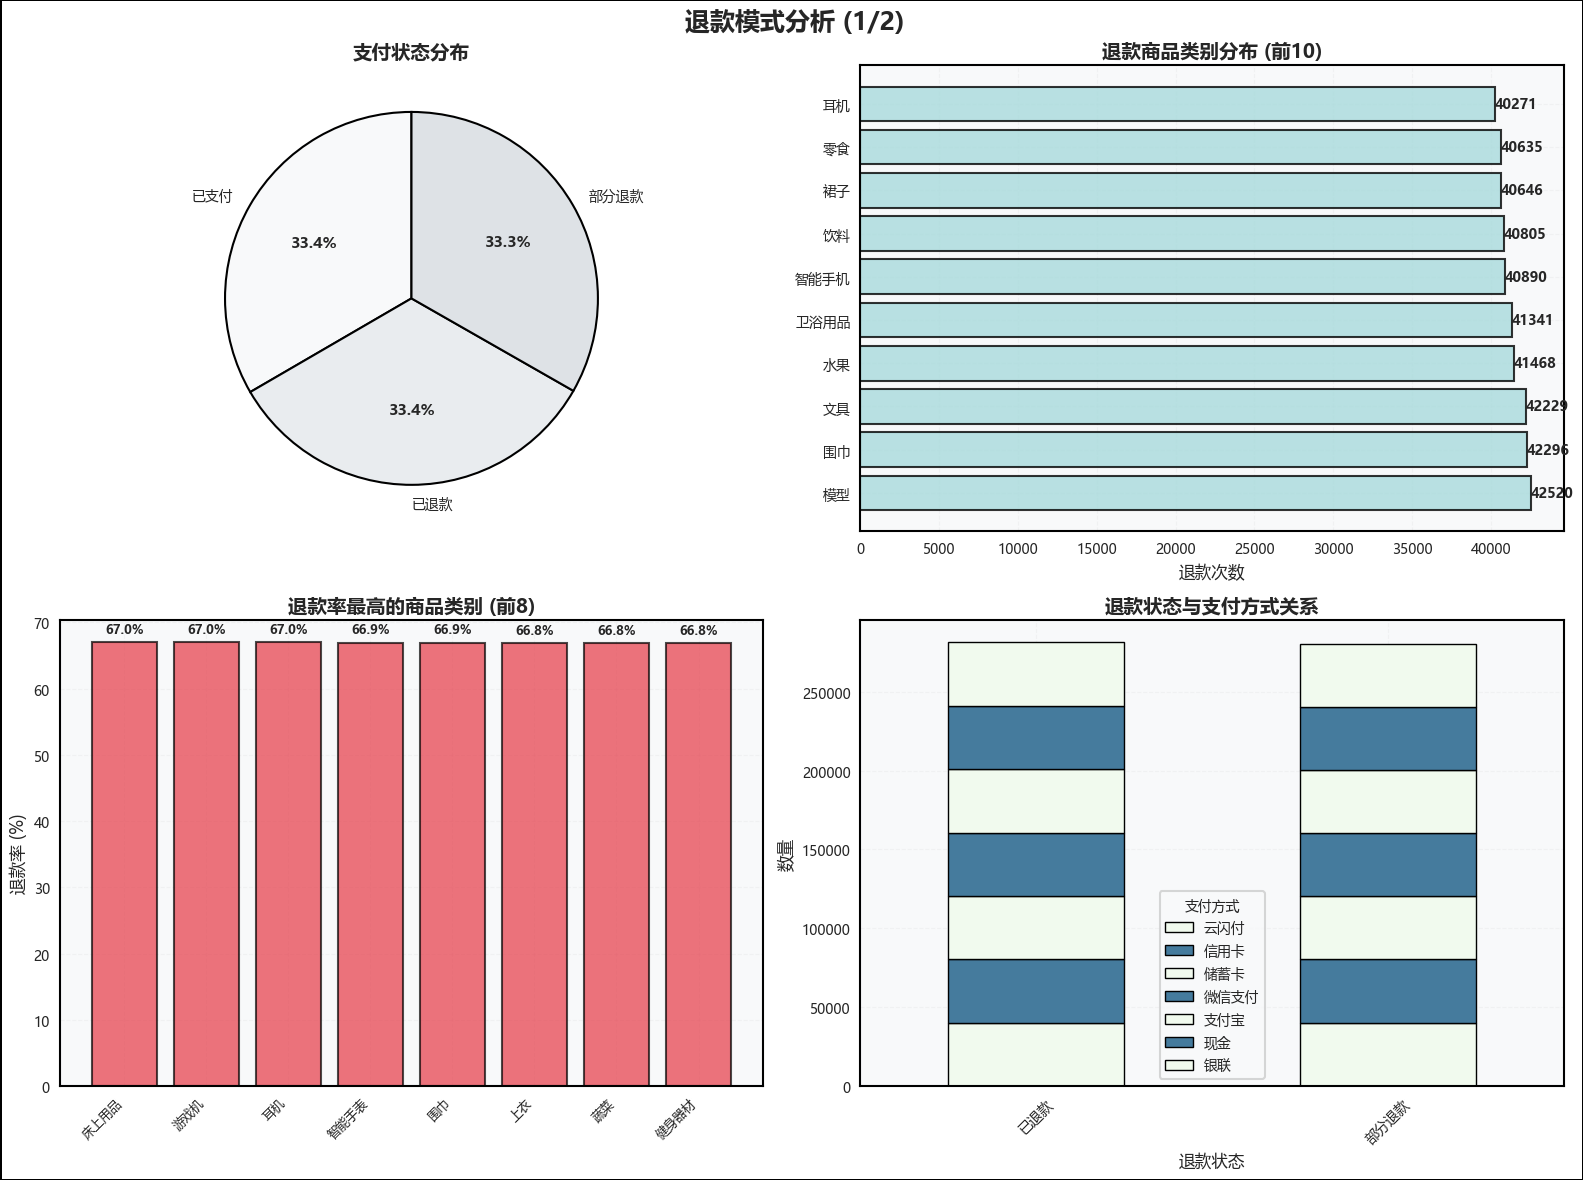

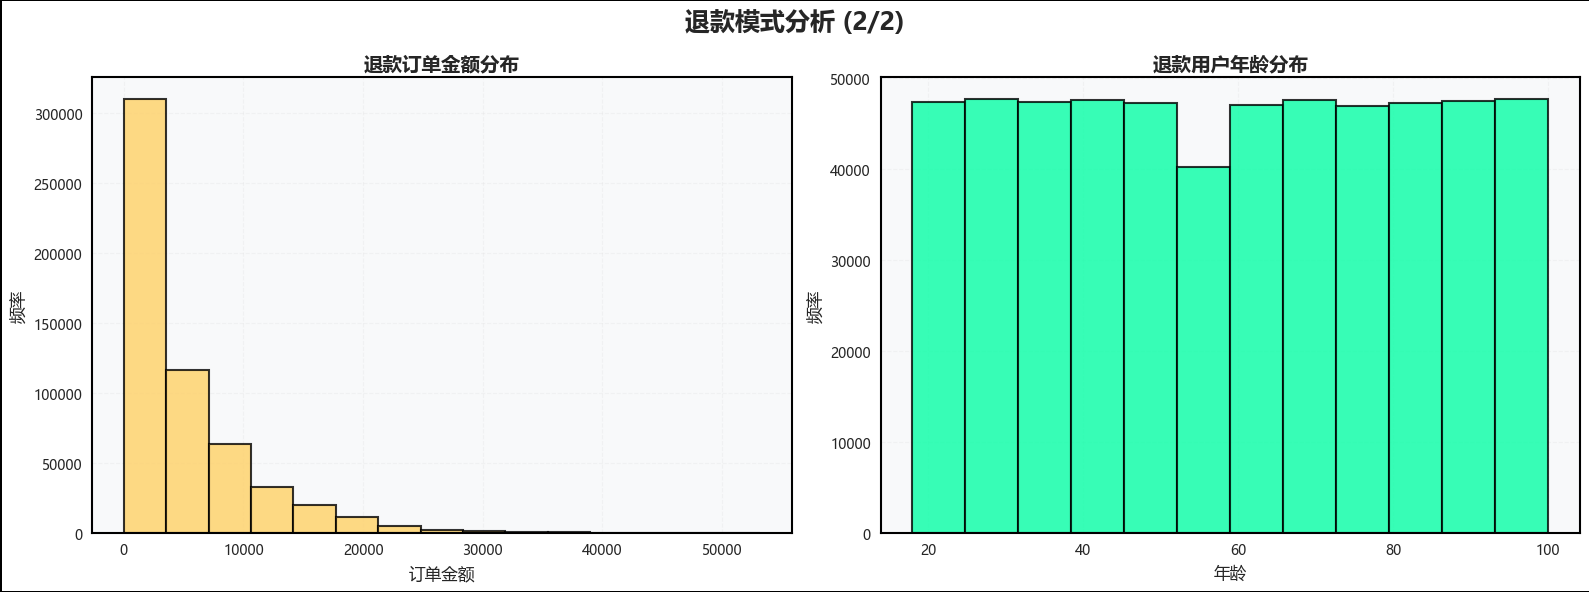


=== 可视化图表数值结果 ===
支付状态分布数值:
已支付: 281397 (33.4%)
已退款: 281304 (33.4%)
部分退款: 280395 (33.3%)

退款商品类别分布前10:
1. 模型: 42520 次
2. 围巾: 42296 次
3. 文具: 42229 次
4. 水果: 41468 次
5. 卫浴用品: 41341 次
6. 智能手机: 40890 次
7. 饮料: 40805 次
8. 裙子: 40646 次
9. 零食: 40635 次
10. 耳机: 40271 次

退款率最高的类别前8:
1. 床上用品: 66.98%
2. 游戏机: 66.96%
3. 耳机: 66.96%
4. 智能手表: 66.94%
5. 围巾: 66.92%
6. 上衣: 66.84%
7. 蔬菜: 66.80%
8. 健身器材: 66.80%

=== 任务4完成 ===
退款数据已保存到 refund_data_task4.csv
类别退款率已保存到 category_refund_rates_task4.csv
退款关联规则已保存到 refund_association_rules_task4.csv
退款频繁项集已保存到 refund_frequent_itemsets_task4.csv


In [6]:
print("=" * 50)
print("任务4：退款模式分析")
print("=" * 50)

# 1. 退款数据概览
print("\n=== 1. 退款数据概览 ===")

# 统计支付状态分布
payment_status_dist = df_processed['payment_status'].value_counts()
print("支付状态分布:")
for i, (status, count) in enumerate(payment_status_dist.items()):
    percentage = count / len(df_processed) * 100
    print(f"{i+1}. {status}: {count} 次 ({percentage:.2f}%)")

# 筛选退款相关数据
refund_data = df_processed[df_processed['payment_status'].isin(['已退款', '部分退款'])].copy()
print(f"\n退款相关记录数量: {len(refund_data)}")
print(f"退款率: {len(refund_data) / len(df_processed) * 100:.2f}%")

if len(refund_data) > 0:
    # 退款类型分布
    refund_type_dist = refund_data['payment_status'].value_counts()
    print(f"\n退款类型分布:")
    for i, (status, count) in enumerate(refund_type_dist.items()):
        percentage = count / len(refund_data) * 100
        print(f"{i+1}. {status}: {count} 次 ({percentage:.2f}%)")

    # 退款金额统计
    print(f"\n退款相关订单金额统计:")
    print(f"平均订单金额: {refund_data['total_price'].mean():.2f}")
    print(f"中位数订单金额: {refund_data['total_price'].median():.2f}")
    print(f"总退款涉及金额: {refund_data['total_price'].sum():.2f}")

# 2. 退款商品类别分析
print("\n=== 2. 退款商品类别分析 ===")

if len(refund_data) > 0:
    # 统计退款商品类别
    refund_categories = []
    for categories in refund_data['unique_categories']:
        refund_categories.extend(categories)

    refund_category_freq = pd.Series(refund_categories).value_counts()
    print(f"退款商品类别频率 (前12):")
    for i, (category, count) in enumerate(refund_category_freq.head(12).items()):
        print(f"{i+1}. {category}: {count} 次")

    # 计算各类别的退款率
    all_categories = []
    for categories in df_processed['unique_categories']:
        all_categories.extend(categories)
    all_category_freq = pd.Series(all_categories).value_counts()

    # 计算退款率
    category_refund_rate = {}
    for category in all_category_freq.index:
        total_count = all_category_freq[category]
        refund_count = refund_category_freq.get(category, 0)
        refund_rate = refund_count / total_count if total_count > 0 else 0
        category_refund_rate[category] = {
            'total_count': total_count,
            'refund_count': refund_count,
            'refund_rate': refund_rate
        }

    # 按退款率排序
    refund_rate_df = pd.DataFrame(category_refund_rate).T
    refund_rate_sorted = refund_rate_df.sort_values('refund_rate', ascending=False)

    print(f"\n各类别退款率 (前12):")
    for i, (idx, row) in enumerate(refund_rate_sorted.head(12).iterrows()):
        print(f"{i+1}. {idx}: 总购买{int(row['total_count'])}次, 退款{int(row['refund_count'])}次, "
              f"退款率{row['refund_rate']*100:.2f}%")

# 3. 退款关联规则挖掘
print("\n=== 3. 退款关联规则挖掘 ===")

if len(refund_data) > 0:
    # 准备退款关联分析数据
    refund_transactions = []
    for idx, row in refund_data.iterrows():
        # 为每个退款记录添加退款状态和商品类别
        transaction = [f"退款状态_{row['payment_status']}"] + [f"类别_{cat}" for cat in row['unique_categories']]
        refund_transactions.append(transaction)

    print(f"退款交易记录数量: {len(refund_transactions)}")

    if len(refund_transactions) > 0:
        # 转换数据格式
        te_refund = TransactionEncoder()
        te_refund_ary = te_refund.fit(refund_transactions).transform(refund_transactions)
        df_refund_encoded = pd.DataFrame(te_refund_ary, columns=te_refund.columns_)

        print(f"转换后数据形状: {df_refund_encoded.shape}")

        # 挖掘频繁项集
        min_support_refund = 0.005  # 支持度 >= 0.005
        frequent_itemsets_refund = apriori(df_refund_encoded,
                                         min_support=min_support_refund,
                                         use_colnames=True,
                                         verbose=1)

        print(f"找到 {len(frequent_itemsets_refund)} 个退款频繁项集")

        if len(frequent_itemsets_refund) > 0:
            print("\n退款频繁项集 (前8):")
            frequent_refund_sorted = frequent_itemsets_refund.sort_values('support', ascending=False)
            for i, (idx, row) in enumerate(frequent_refund_sorted.head(8).iterrows()):
                itemset_str = ', '.join(list(row['itemsets']))
                print(f"{i+1}. [{itemset_str}] - 支持度: {row['support']:.4f}")

            # 生成关联规则
            min_confidence_refund = 0.4  # 置信度 >= 0.4
            rules_refund = association_rules(frequent_itemsets_refund,
                                           metric="confidence",
                                           min_threshold=min_confidence_refund)

            if len(rules_refund) > 0:
                # 计算提升度
                rules_refund['lift'] = rules_refund['confidence'] / rules_refund['consequent support']
                rules_refund_sorted = rules_refund.sort_values(['confidence', 'support'], ascending=False)

                print(f"\n找到 {len(rules_refund_sorted)} 条退款关联规则")
                print("\n退款关联规则详情 (前8条):")
                for i, (idx, rule) in enumerate(rules_refund_sorted.head(8).iterrows()):
                    antecedents = ', '.join([str(x) for x in rule['antecedents']])
                    consequents = ', '.join([str(x) for x in rule['consequents']])
                    print(f"{i+1}. {antecedents} => {consequents}")
                    print(f"   支持度: {rule['support']:.4f} | 置信度: {rule['confidence']:.4f} | "
                          f"提升度: {rule['lift']:.4f}")

                # 筛选与退款状态直接相关的规则
                refund_status_rules = rules_refund_sorted[
                    rules_refund_sorted['antecedents'].apply(lambda x: any('退款状态_' in str(item) for item in x)) |
                    rules_refund_sorted['consequents'].apply(lambda x: any('退款状态_' in str(item) for item in x))
                ]

                print(f"\n涉及退款状态的关联规则数量: {len(refund_status_rules)}")
                if len(refund_status_rules) > 0:
                    print("\n退款状态关联规则 (前5条):")
                    for i, (idx, rule) in enumerate(refund_status_rules.head(5).iterrows()):
                        antecedents = ', '.join([str(x) for x in rule['antecedents']])
                        consequents = ', '.join([str(x) for x in rule['consequents']])
                        print(f"{i+1}. {antecedents} => {consequents}")
                        print(f"   支持度: {rule['support']:.4f} | 置信度: {rule['confidence']:.4f} | "
                              f"提升度: {rule['lift']:.4f}")

# 4. 退款模式深度分析
print("\n=== 4. 退款模式深度分析 ===")

if len(refund_data) > 0:
    # 退款与支付方式关系
    refund_payment_cross = pd.crosstab(refund_data['payment_status'], refund_data['payment_method'])
    print("退款状态与支付方式交叉分析:")
    print(refund_payment_cross)

    # 退款与用户特征关系
    print(f"\n退款用户特征分析:")
    print(f"退款用户平均年龄: {refund_data['age'].mean():.1f}")
    print(f"退款用户平均收入: {refund_data['income'].mean():.2f}")

    # 退款用户性别分布
    refund_gender_dist = refund_data['gender'].value_counts()
    print(f"退款用户性别分布:")
    for i, (gender, count) in enumerate(refund_gender_dist.items()):
        percentage = count / len(refund_data) * 100
        print(f"{i+1}. {gender}: {count} 次 ({percentage:.2f}%)")

    # 退款用户国家分布
    refund_country_dist = refund_data['country'].value_counts().head(8)
    print(f"退款用户国家分布 (前8):")
    for i, (country, count) in enumerate(refund_country_dist.items()):
        print(f"{i+1}. {country}: {count} 次")

# 5. 退款风险商品组合识别
print("\n=== 5. 退款风险商品组合识别 ===")

if len(refund_data) > 0:
    # 分析多商品类别组合的退款风险
    category_combinations = {}

    # 统计所有商品类别组合
    for categories in df_processed['unique_categories']:
        if len(categories) > 1:  # 多类别组合
            combo = tuple(sorted(categories))
            if combo not in category_combinations:
                category_combinations[combo] = {'total': 0, 'refund': 0}
            category_combinations[combo]['total'] += 1

    # 统计退款的商品类别组合
    for categories in refund_data['unique_categories']:
        if len(categories) > 1:
            combo = tuple(sorted(categories))
            if combo in category_combinations:
                category_combinations[combo]['refund'] += 1

    # 计算退款风险率
    risk_combinations = []
    for combo, stats in category_combinations.items():
        if stats['total'] >= 3:  # 只考虑出现3次以上的组合
            risk_rate = stats['refund'] / stats['total']
            risk_combinations.append({
                'combination': combo,
                'total_count': stats['total'],
                'refund_count': stats['refund'],
                'risk_rate': risk_rate
            })

    # 按风险率排序
    risk_combinations_sorted = sorted(risk_combinations, key=lambda x: x['risk_rate'], reverse=True)

    print(f"高风险商品组合 (前8):")
    for i, combo_data in enumerate(risk_combinations_sorted[:8]):
        combo_str = ' + '.join(combo_data['combination'])
        print(f"{i+1}. {combo_str}: "
              f"总计{combo_data['total_count']}次, "
              f"退款{combo_data['refund_count']}次, "
              f"风险率{combo_data['risk_rate']*100:.1f}%")

# 6. 可视化退款模式分析 - 分为两张大图
print("\n=== 6. 可视化退款模式分析 ===")

if len(refund_data) > 0:
    # 第一张大图 - 4个子图
    fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
    fig1.patch.set_facecolor('white')
    fig1.patch.set_edgecolor('black')
    fig1.patch.set_linewidth(2)
    plt.subplots_adjust(top=0.9)
    fig1.suptitle('退款模式分析 (1/2)', fontsize=18, fontweight='bold')

    # 6.1 支付状态分布饼图
    colors1 = ['#f8f9fa', '#e9ecef', '#dee2e6']
    wedges, texts, autotexts = axes1[0,0].pie(payment_status_dist.values, labels=payment_status_dist.index,
                                             autopct='%1.1f%%', startangle=90, colors=colors1,
                                             wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    axes1[0,0].set_title('支付状态分布', fontsize=14, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

    # 6.2 退款商品类别分布
    top_refund_categories = refund_category_freq.head(10)
    bars2 = axes1[0,1].barh(range(len(top_refund_categories)), top_refund_categories.values,
                           color='#a8dadc', edgecolor='black', linewidth=1.5, alpha=0.8)
    axes1[0,1].set_yticks(range(len(top_refund_categories)))
    axes1[0,1].set_yticklabels(top_refund_categories.index, fontsize=10)
    axes1[0,1].set_title('退款商品类别分布 (前10)', fontsize=14, fontweight='bold')
    axes1[0,1].set_xlabel('退款次数', fontsize=12)
    axes1[0,1].grid(True, alpha=0.3)

    # 添加数值标注
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        axes1[0,1].text(width + 0.2, bar.get_y() + bar.get_height()/2.,
                       f'{int(width)}', ha='left', va='center',
                       fontsize=10, fontweight='bold')

    # 6.3 退款率最高的类别
    top_refund_rate = refund_rate_sorted.head(8)['refund_rate'] * 100
    bars3 = axes1[1,0].bar(range(len(top_refund_rate)), top_refund_rate.values,
                          color='#e63946', edgecolor='black', linewidth=1.5, alpha=0.7)
    axes1[1,0].set_xticks(range(len(top_refund_rate)))
    axes1[1,0].set_xticklabels(top_refund_rate.index, rotation=45, ha='right', fontsize=9)
    axes1[1,0].set_title('退款率最高的商品类别 (前8)', fontsize=14, fontweight='bold')
    axes1[1,0].set_ylabel('退款率 (%)', fontsize=12)
    axes1[1,0].grid(True, alpha=0.3)

    # 添加数值标注
    for bar in bars3:
        height = bar.get_height()
        axes1[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{height:.1f}%', ha='center', va='bottom',
                       fontsize=9, fontweight='bold')

    # 6.4 退款与支付方式关系
    refund_payment_cross.plot(kind='bar', ax=axes1[1,1], stacked=True,
                             color=['#f1faee', '#457b9d'], edgecolor='black', linewidth=1)
    axes1[1,1].set_title('退款状态与支付方式关系', fontsize=14, fontweight='bold')
    axes1[1,1].set_xlabel('退款状态', fontsize=12)
    axes1[1,1].set_ylabel('数量', fontsize=12)
    axes1[1,1].tick_params(axis='x', rotation=45)
    axes1[1,1].legend(title='支付方式')
    axes1[1,1].grid(True, alpha=0.3)

    # 美化边框
    for ax in axes1.flat:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # 第二张大图 - 2个子图
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.patch.set_facecolor('white')
    fig2.patch.set_edgecolor('black')
    fig2.patch.set_linewidth(2)
    plt.subplots_adjust(top=0.85)
    fig2.suptitle('退款模式分析 (2/2)', fontsize=18, fontweight='bold')

    # 6.5 退款金额分布
    axes2[0].hist(refund_data['total_price'], bins=15, color='#ffd166', alpha=0.8,
                 edgecolor='black', linewidth=1.5)
    axes2[0].set_title('退款订单金额分布', fontsize=14, fontweight='bold')
    axes2[0].set_xlabel('订单金额', fontsize=12)
    axes2[0].set_ylabel('频率', fontsize=12)
    axes2[0].grid(True, alpha=0.3)

    # 6.6 退款用户年龄分布
    axes2[1].hist(refund_data['age'], bins=12, color='#06ffa5', alpha=0.8,
                 edgecolor='black', linewidth=1.5)
    axes2[1].set_title('退款用户年龄分布', fontsize=14, fontweight='bold')
    axes2[1].set_xlabel('年龄', fontsize=12)
    axes2[1].set_ylabel('频率', fontsize=12)
    axes2[1].grid(True, alpha=0.3)

    # 美化边框
    for ax in axes2:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # 打印可视化结果数值
    print("\n=== 可视化图表数值结果 ===")
    print("支付状态分布数值:")
    for status, count in payment_status_dist.items():
        percentage = count / len(df_processed) * 100
        print(f"{status}: {count} ({percentage:.1f}%)")

    print("\n退款商品类别分布前10:")
    for i, (category, count) in enumerate(top_refund_categories.items()):
        print(f"{i+1}. {category}: {count} 次")

    print("\n退款率最高的类别前8:")
    for i, (category, rate) in enumerate(top_refund_rate.items()):
        print(f"{i+1}. {category}: {rate:.2f}%")

print("\n=== 任务4完成 ===")

# 保存结果
if len(refund_data) > 0:
    refund_data.to_csv('refund_data_task4.csv', index=False)
    refund_rate_sorted.to_csv('category_refund_rates_task4.csv')
    print("退款数据已保存到 refund_data_task4.csv")
    print("类别退款率已保存到 category_refund_rates_task4.csv")

if 'rules_refund_sorted' in locals() and len(rules_refund_sorted) > 0:
    rules_refund_sorted.to_csv('refund_association_rules_task4.csv', index=False)
    print("退款关联规则已保存到 refund_association_rules_task4.csv")

if 'frequent_itemsets_refund' in locals() and len(frequent_itemsets_refund) > 0:
    frequent_itemsets_refund.to_csv('refund_frequent_itemsets_task4.csv', index=False)
    print("退款频繁项集已保存到 refund_frequent_itemsets_task4.csv")